## SOLVE CARTPOLOE USING DQN

In [1]:
import numpy as np
import gym
import random
from collections import deque
from matplotlib import pyplot as plt
from videofig import videofig
%matplotlib inline
# FOLLOWINGS ARE FOR ANIMATION
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display
print ('PACKAGES LOADED')

PACKAGES LOADED


#### ANIMATE FUNCTION 

In [2]:
def display_frames_as_gif(frames):
    plt.figure(figsize=(8, 4), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    title_obj = plt.title(0)
    def animate(i):
        patch.set_data(frames[i])
        plt.setp(title_obj, color='k', text=('Time: %d' % (i)))
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))
print ("ANIMATE FUNCTION READY")

ANIMATE FUNCTION READY


#### DQN CODE

In [ ]:
import random
import tensorflow as tf
from collections import deque
class ReplayBuffer(object):
    # INIT REPLAY BUFFER
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.num_experiences = 0
        self.buffer = deque()
    # GET RANDOM REPLAY
    def getBatch(self, batch_size):
        # random draw N
        return random.sample(self.buffer, batch_size)
    # RETURN BUFFER SIZE
    def size(self):
        return self.buffer_size
    # ADD (S, A, R, S') TO REPLAY
    def add(self, state, action, reward, next_state, done):
        new_experience = (state, action, reward, next_state, done)
        if self.num_experiences < self.buffer_size:
            self.buffer.append(new_experience)
            self.num_experiences += 1
        else:
            self.buffer.popleft()
            self.buffer.append(new_experience)
    # COUNT 
    def count(self):
        # if buffer is full, return buffer size
        # otherwise, return experience counter
        return self.num_experiences
    # INIT
    def erase(self):
        self.buffer = deque()
        self.num_experiences = 0

In [3]:
# DEEP Q NETWORK
class NeuralQLearner(object):
    def __init__(self, session,
                     optimizer,
                     q_network,
                     state_dim,
                     num_actions,
                     batch_size=32,
                     init_exp=0.5,       # initial exploration prob
                     final_exp=0.1,      # final exploration prob
                     anneal_steps=10000, # N steps for annealing exploration
                     replay_buffer_size=10000,
                     store_replay_every=5, # how frequent to store experience
                     discount_factor=0.9, # discount future rewards
                     target_update_rate=0.01,
                     reg_param=0.01, # regularization constants
                     max_gradient=5, # max gradient norms
                     double_q_learning=False,
                     summary_writer=None,
                     summary_every=100):
        # TENSORFLOW THINGS
        self.session        = session
        self.optimizer      = optimizer
        self.summary_writer = summary_writer

        # MODEL (DQN AND REPLAY MEMORY)
        self.q_network     = q_network
        self.replay_buffer = ReplayBuffer(buffer_size=replay_buffer_size)

        # Q LEARNING PARAMETERS
        self.batch_size      = batch_size
        self.state_dim       = state_dim
        self.num_actions     = num_actions
        self.exploration     = init_exp
        self.init_exp        = init_exp
        self.final_exp       = final_exp
        self.anneal_steps    = anneal_steps
        self.discount_factor = discount_factor
        self.target_update_rate = target_update_rate
        self.double_q_learning = double_q_learning

        # GRADIENT CLIPPING AND REG
        self.max_gradient = max_gradient
        self.reg_param    = reg_param

        # COUNTERS
        self.store_replay_every   = store_replay_every
        self.store_experience_cnt = 0
        self.train_iteration      = 0

        # CERATE AND INIT
        self.create_variables()
        var_lists = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        self.session.run(tf.variables_initializer(var_lists))

        # make sure all variables are initialized
        self.session.run(tf.assert_variables_initialized())

        if self.summary_writer is not None:
            # graph was not available when journalist was created
            self.summary_writer.add_graph(self.session.graph)
            self.summary_every = summary_every

    # CREATE A BUNCH OF INTERMEDIATE VARIABLES 
    def create_variables(self):
        # compute action from a state: a* = argmax_a Q(s_t,a)
        with tf.name_scope("predict_actions"):
            # raw state representation
            self.states = tf.placeholder(tf.float32, (None, self.state_dim), name="states")
            # initialize Q network
            with tf.variable_scope("q_network"):
                self.q_outputs = self.q_network(self.states)
            # predict actions from Q network
            self.action_scores = tf.identity(self.q_outputs, name="action_scores")
            tf.summary.histogram("action_scores", self.action_scores)
            self.predicted_actions = tf.argmax(self.action_scores, axis=1, name="predicted_actions")

        # estimate rewards using the next state: r(s_t,a_t) + argmax_a Q(s_{t+1}, a)
        with tf.name_scope("estimate_future_rewards"):
            self.next_states = tf.placeholder(tf.float32, (None, self.state_dim), name="next_states")
            self.next_state_mask = tf.placeholder(tf.float32, (None,), name="next_state_masks")

            if self.double_q_learning:
                # THIS PART IS FOR DDQN
                with tf.variable_scope("q_network", reuse=True):
                    self.q_next_outputs = self.q_network(self.next_states)
                self.action_selection = tf.argmax(tf.stop_gradient(self.q_next_outputs), 1, name="action_selection")
                tf.summary.histogram("action_selection", self.action_selection)
                self.action_selection_mask = tf.one_hot(self.action_selection, self.num_actions, 1, 0)
                with tf.variable_scope("target_network"):
                    self.target_outputs = self.q_network(self.next_states) * tf.cast(self.action_selection_mask, tf.float32)
                self.action_evaluation = tf.reduce_sum(self.target_outputs, axis=[1,])
                tf.summary.histogram("action_evaluation", self.action_evaluation)
                self.target_values = self.action_evaluation * self.next_state_mask
            else:
                # THIS PART IS FOR DQN
                with tf.variable_scope("target_network"):
                    self.target_outputs = self.q_network(self.next_states)
                self.next_action_scores = tf.stop_gradient(self.target_outputs)
                self.target_values = tf.reduce_max(self.next_action_scores, axis=[1,]) * self.next_state_mask
                tf.summary.histogram("next_action_scores", self.next_action_scores)

            self.rewards = tf.placeholder(tf.float32, (None,), name="rewards")
            self.future_rewards = self.rewards + self.discount_factor * self.target_values

        # COMPUTE LOSS AND GRADIENTS
        with tf.name_scope("compute_temporal_differences"):
            # compute temporal difference loss
            self.action_mask = tf.placeholder(tf.float32, (None, self.num_actions), name="action_mask")
            self.masked_action_scores = tf.reduce_sum(self.action_scores * self.action_mask, axis=[1,])
            # TEMPORAL DIFFERENCE 
            self.temp_diff = self.masked_action_scores - self.future_rewards
            self.td_loss = tf.reduce_mean(tf.square(self.temp_diff))
            # REGULARIZED LOSS
            q_network_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="q_network")
            self.reg_loss = self.reg_param * tf.reduce_sum([tf.reduce_sum(tf.square(x)) for x in q_network_variables])
            # TOTAL LOSS
            self.loss = self.td_loss + self.reg_loss
            gradients = self.optimizer.compute_gradients(self.loss)
            # GRADIENT CLIPPING
            for i, (grad, var) in enumerate(gradients):
                if grad is not None: 
                    gradients[i] = (tf.clip_by_norm(grad, self.max_gradient), var)
            # SUMMARIZE
            for grad, var in gradients:
                tf.summary.histogram(var.name, var)
                if grad is not None:
                    tf.summary.histogram(var.name + '/gradients', grad)
            self.train_op = self.optimizer.apply_gradients(gradients)

        # UPDATE TARGET NETWORK
        with tf.name_scope("update_target_network"):
            self.target_network_update = []
            # slowly update target network parameters with Q network parameters
            q_network_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="q_network")
            target_network_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="target_network")
            for v_source, v_target in zip(q_network_variables, target_network_variables):
                # this is equivalent to target = (1-alpha) * target + alpha * source
                update_op = v_target.assign_sub(self.target_update_rate * (v_target - v_source))
                self.target_network_update.append(update_op)
            self.target_network_update = tf.group(*self.target_network_update)

        # SUMMARIES
        tf.summary.scalar("td_loss", self.td_loss)
        tf.summary.scalar("reg_loss", self.reg_loss)
        tf.summary.scalar("total_loss", self.loss)
        tf.summary.scalar("exploration", self.exploration)
        self.summarize = tf.summary.merge_all()
        self.no_op = tf.no_op()

    # STORE EXPERIENCE
    def storeExperience(self, state, action, reward, next_state, done):
        if self.store_experience_cnt % self.store_replay_every == 0 or done:
            self.replay_buffer.add(state, action, reward, next_state, done)
        self.store_experience_cnt += 1

    # EPS-GREEDY ACTION
    def eGreedyAction(self, states, explore=True):
        if explore and self.exploration > random.random():
            return random.randint(0, self.num_actions-1)
        else:
            return self.session.run(self.predicted_actions, {self.states: states})[0]

    def annealExploration(self, stategy='linear'):
        ratio = max((self.anneal_steps - self.train_iteration)/float(self.anneal_steps), 0)
        self.exploration = (self.init_exp - self.final_exp) * ratio + self.final_exp

    # UPDATE MODEL
    def updateModel(self):
        # WAIT UNTIL EXPERIENCE TO BE ENOUGH
        if self.replay_buffer.count() < self.batch_size:
            return
        batch           = self.replay_buffer.getBatch(self.batch_size)
        states          = np.zeros((self.batch_size, self.state_dim))
        rewards         = np.zeros((self.batch_size,))
        action_mask     = np.zeros((self.batch_size, self.num_actions))
        next_states     = np.zeros((self.batch_size, self.state_dim))
        next_state_mask = np.zeros((self.batch_size,))
        for k, (s0, a, r, s1, done) in enumerate(batch):
            states[k] = s0
            rewards[k] = r
            action_mask[k][a] = 1
            # check terminal state
            if not done:
                next_states[k] = s1
                next_state_mask[k] = 1
        # SUMMARY
        calculate_summaries = self.train_iteration % self.summary_every == 0 and self.summary_writer is not None
        # MINI-BATCH LEARNING OF Q FUNCTION
        cost, _, summary_str = self.session.run([
              self.loss,
              self.train_op,
              self.summarize if calculate_summaries else self.no_op
            ], {
              self.states:          states,
              self.next_states:     next_states,
              self.next_state_mask: next_state_mask,
              self.action_mask:     action_mask,
              self.rewards:         rewards
            })

        # UPDATE TARGET NETWROK
        self.session.run(self.target_network_update)
        # emit summaries
        if calculate_summaries:
            self.summary_writer.add_summary(summary_str, self.train_iteration)
        self.annealExploration()
        self.train_iteration += 1
print ("DQN READY")

DQN READY


### INITIALIZE ENVIRONEMT

In [4]:
env_name = 'CartPole-v0'
env = gym.make(env_name)
print ("[%s] READY" % (env_name))
print ("STATE SPACE:  %s" % (env.observation_space))
print ("ACTION SPACE: %s" % (env.action_space))

[2017-05-29 16:37:29,266] Making new env: CartPole-v0


[CartPole-v0] READY
STATE SPACE:  Box(4,)
ACTION SPACE: Discrete(2)


#### OPEN SESSION

In [5]:
sess        = tf.Session()
optimizer   = tf.train.RMSPropOptimizer(learning_rate=0.0001, decay=0.9)
writer      = tf.summary.FileWriter("/tmp/{}-experiment-1".format(env_name))
print ("SESSION READY")

SESSION READY


#### DEFINE Q-FUNTION

In [6]:
state_dim   = env.observation_space.shape[0]
num_actions = env.action_space.n
def observation_to_action(states):
    W1 = tf.get_variable("W1", [state_dim, 20],
                       initializer=tf.random_normal_initializer())
    b1 = tf.get_variable("b1", [20],
                       initializer=tf.constant_initializer(0))
    h1 = tf.nn.relu(tf.matmul(states, W1) + b1)
    W2 = tf.get_variable("W2", [20, num_actions],
                       initializer=tf.random_normal_initializer())
    b2 = tf.get_variable("b2", [num_actions],
                       initializer=tf.constant_initializer(0))
    q = tf.matmul(h1, W2) + b2
    return q

#### INSTANTIATE Q LEARNER

In [7]:
q_learner = NeuralQLearner(sess,
                           optimizer,
                           observation_to_action,
                           state_dim,
                           num_actions,
                           summary_writer=writer)

INFO:tensorflow:Summary name q_network/W1:0 is illegal; using q_network/W1_0 instead.


[2017-05-29 16:37:29,830] Summary name q_network/W1:0 is illegal; using q_network/W1_0 instead.


INFO:tensorflow:Summary name q_network/W1:0/gradients is illegal; using q_network/W1_0/gradients instead.


[2017-05-29 16:37:29,833] Summary name q_network/W1:0/gradients is illegal; using q_network/W1_0/gradients instead.


INFO:tensorflow:Summary name q_network/b1:0 is illegal; using q_network/b1_0 instead.


[2017-05-29 16:37:29,835] Summary name q_network/b1:0 is illegal; using q_network/b1_0 instead.


INFO:tensorflow:Summary name q_network/b1:0/gradients is illegal; using q_network/b1_0/gradients instead.


[2017-05-29 16:37:29,837] Summary name q_network/b1:0/gradients is illegal; using q_network/b1_0/gradients instead.


INFO:tensorflow:Summary name q_network/W2:0 is illegal; using q_network/W2_0 instead.


[2017-05-29 16:37:29,840] Summary name q_network/W2:0 is illegal; using q_network/W2_0 instead.


INFO:tensorflow:Summary name q_network/W2:0/gradients is illegal; using q_network/W2_0/gradients instead.


[2017-05-29 16:37:29,843] Summary name q_network/W2:0/gradients is illegal; using q_network/W2_0/gradients instead.


INFO:tensorflow:Summary name q_network/b2:0 is illegal; using q_network/b2_0 instead.


[2017-05-29 16:37:29,845] Summary name q_network/b2:0 is illegal; using q_network/b2_0 instead.


INFO:tensorflow:Summary name q_network/b2:0/gradients is illegal; using q_network/b2_0/gradients instead.


[2017-05-29 16:37:29,847] Summary name q_network/b2:0/gradients is illegal; using q_network/b2_0/gradients instead.


INFO:tensorflow:Summary name target_network/W1:0 is illegal; using target_network/W1_0 instead.


[2017-05-29 16:37:29,850] Summary name target_network/W1:0 is illegal; using target_network/W1_0 instead.


INFO:tensorflow:Summary name target_network/b1:0 is illegal; using target_network/b1_0 instead.


[2017-05-29 16:37:29,852] Summary name target_network/b1:0 is illegal; using target_network/b1_0 instead.


INFO:tensorflow:Summary name target_network/W2:0 is illegal; using target_network/W2_0 instead.


[2017-05-29 16:37:29,854] Summary name target_network/W2:0 is illegal; using target_network/W2_0 instead.


INFO:tensorflow:Summary name target_network/b2:0 is illegal; using target_network/b2_0 instead.


[2017-05-29 16:37:29,855] Summary name target_network/b2:0 is illegal; using target_network/b2_0 instead.


#### CONFIG

In [ ]:
MAX_EPISODES    = 10000
MAX_STEPS       = 200
episode_history = deque(maxlen=100)

#### RUN


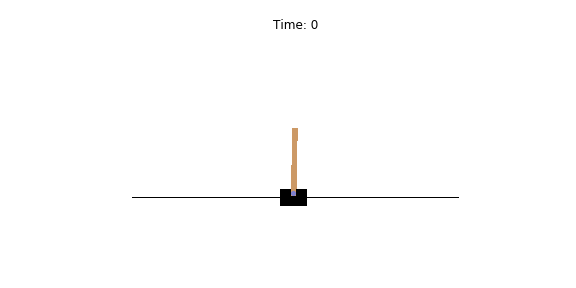
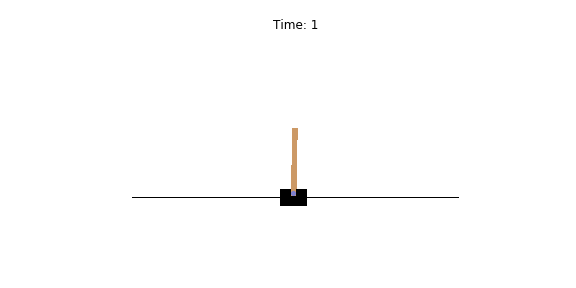
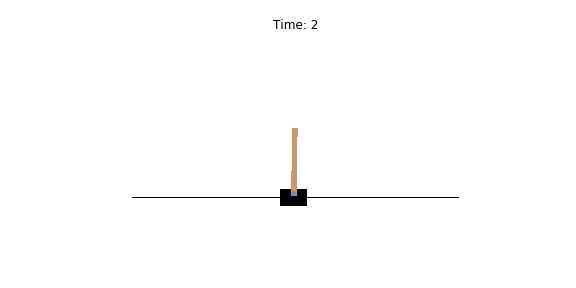
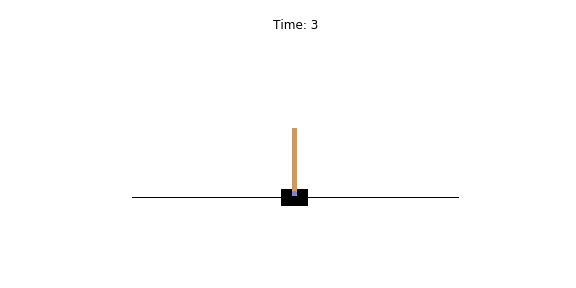
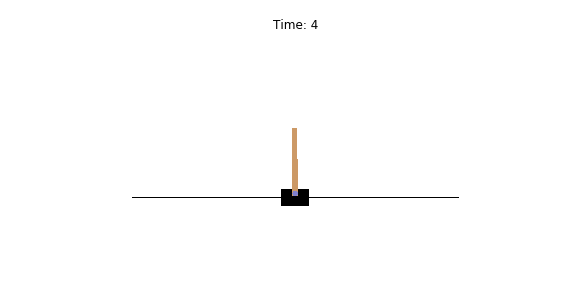
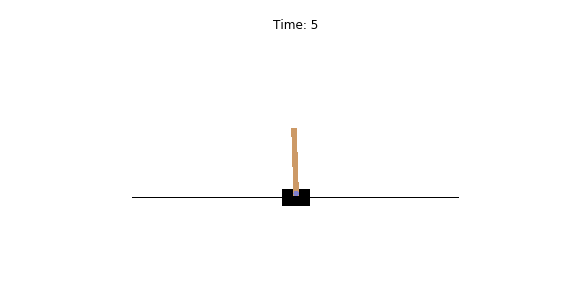
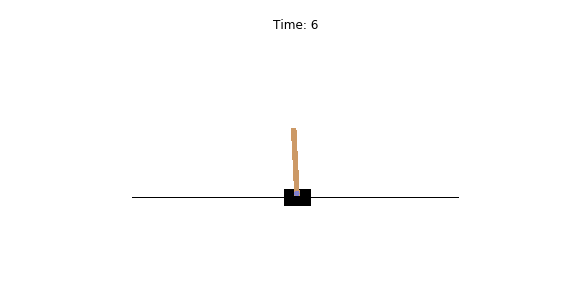
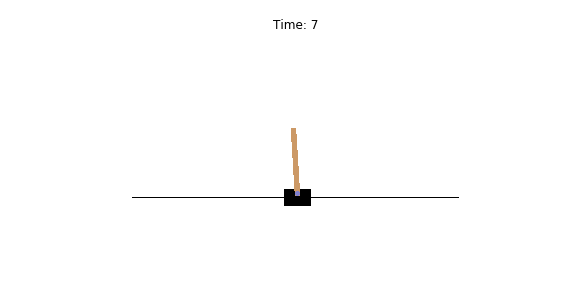
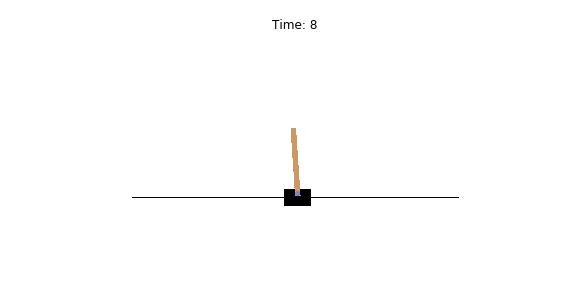
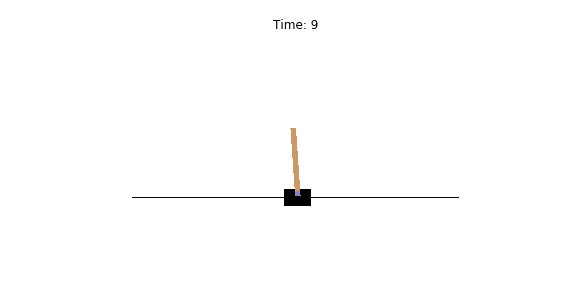
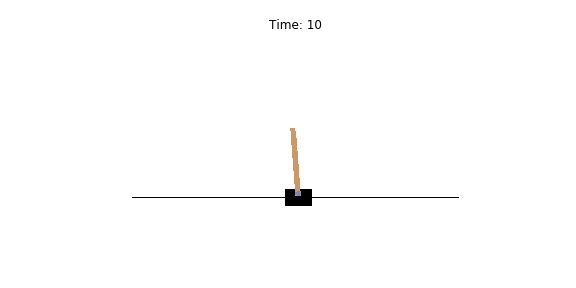
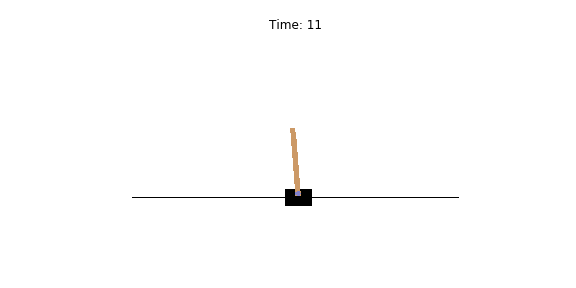
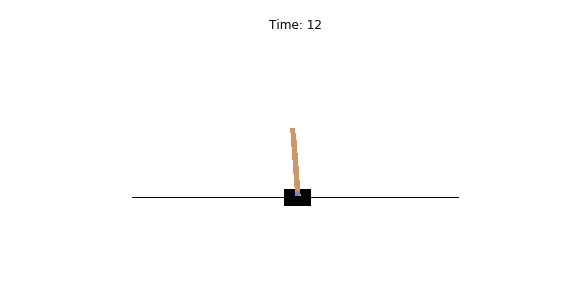
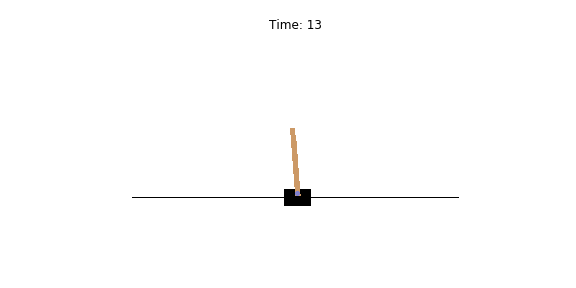
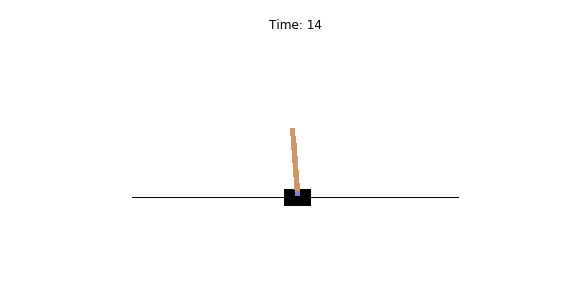
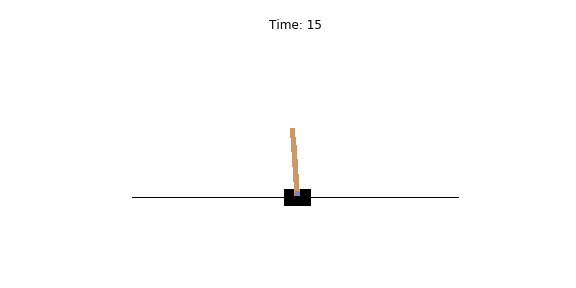
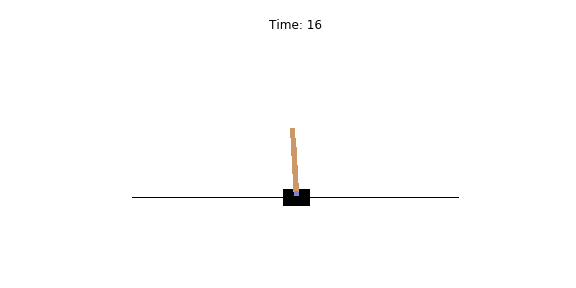
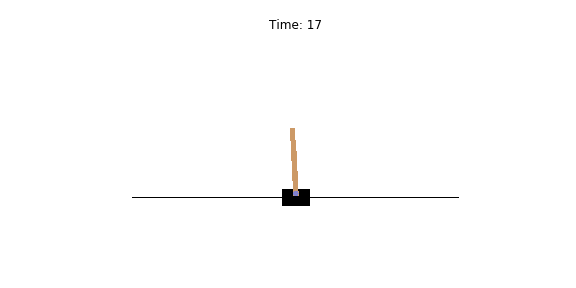
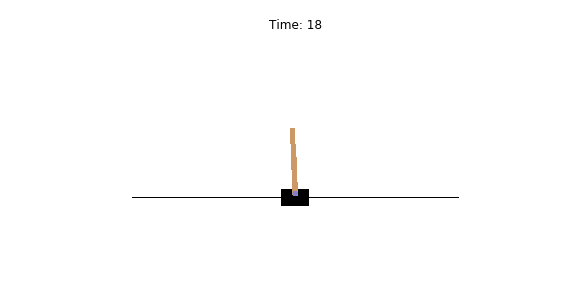
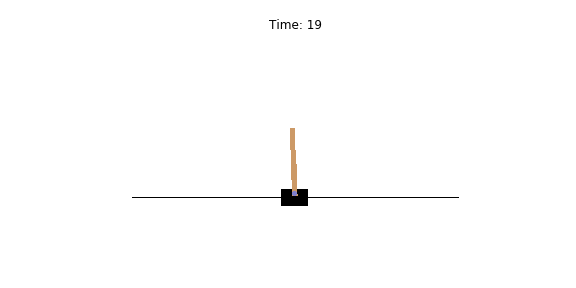
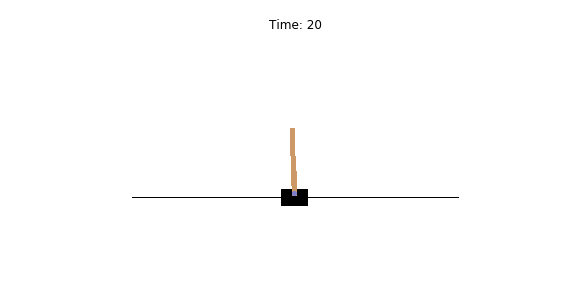
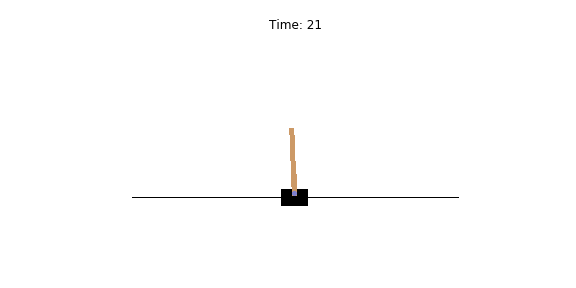
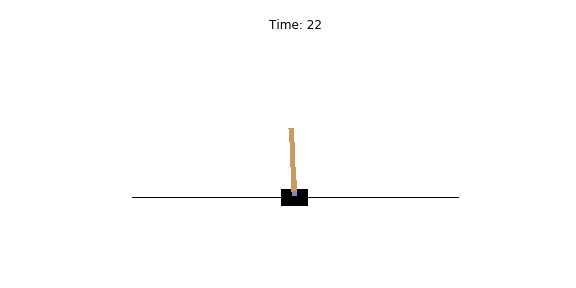
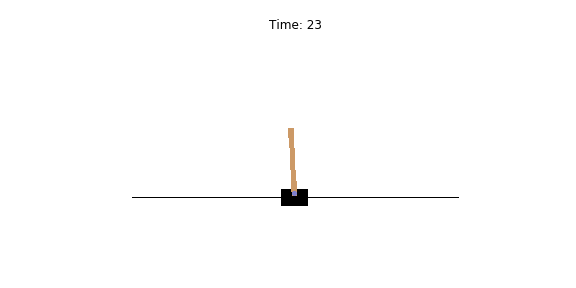
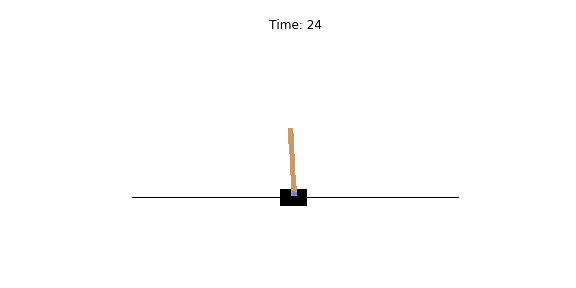
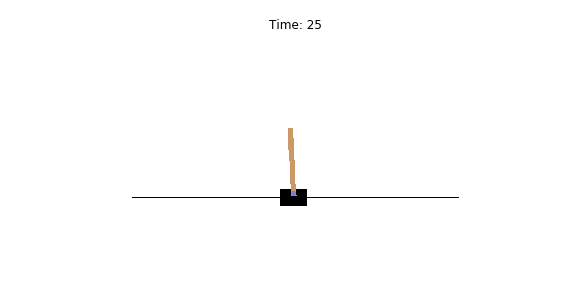
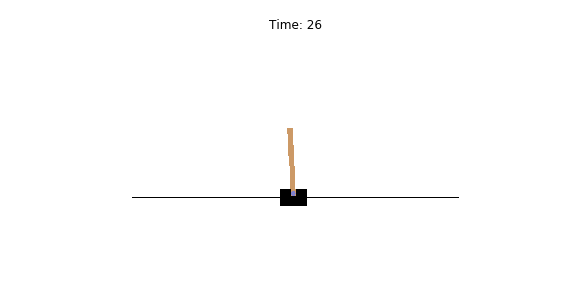
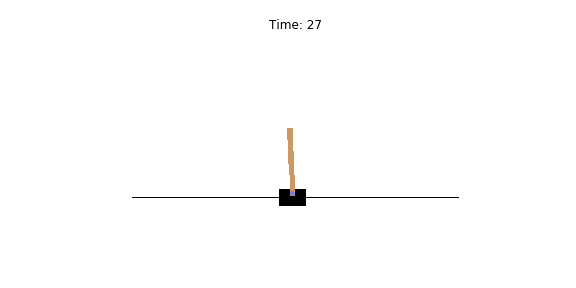
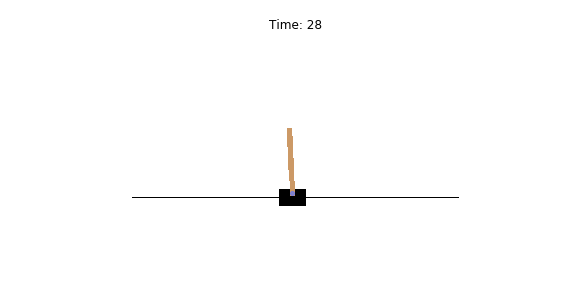
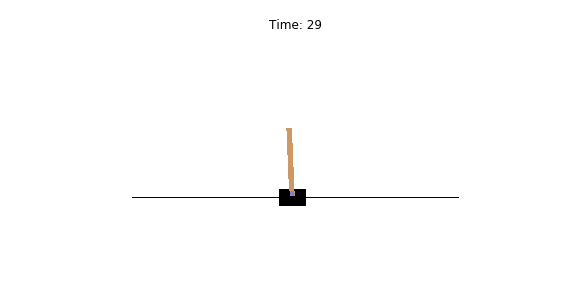
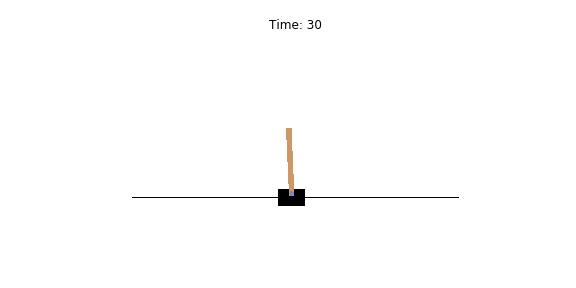
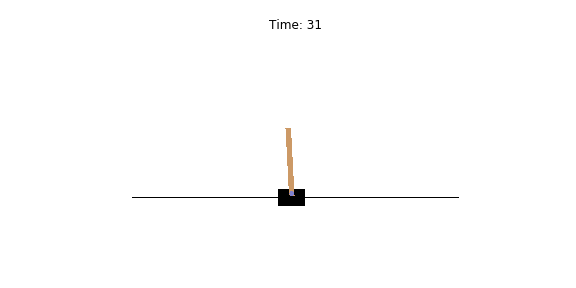
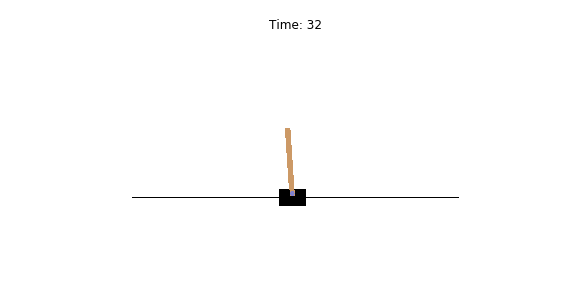
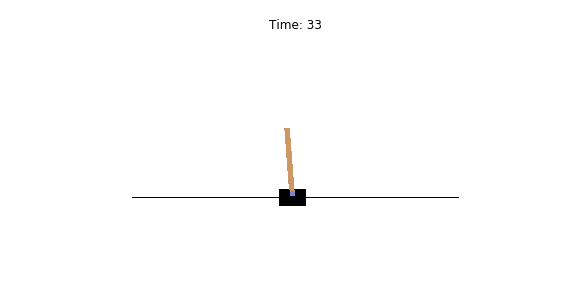
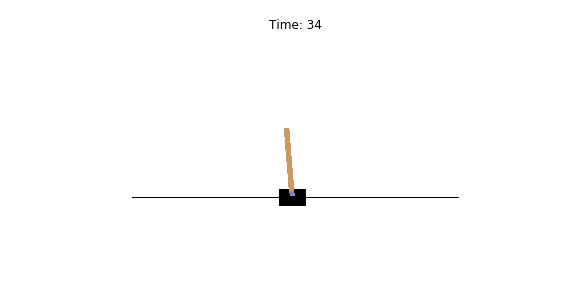
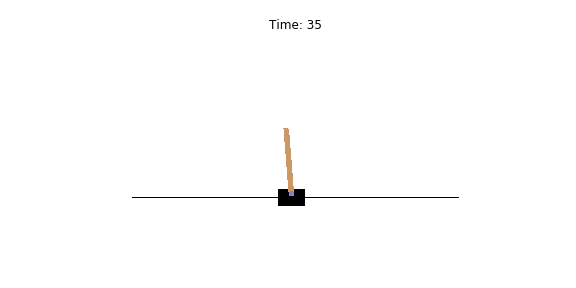
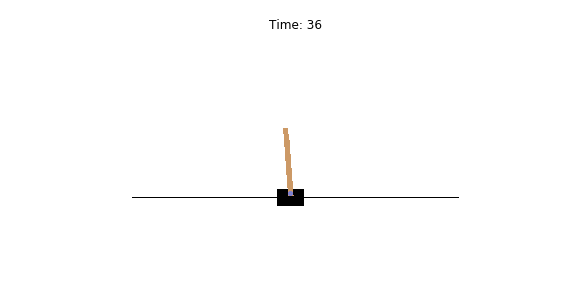
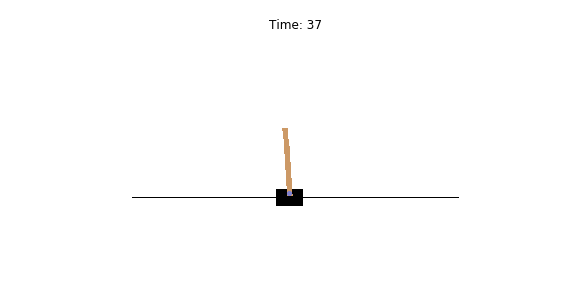
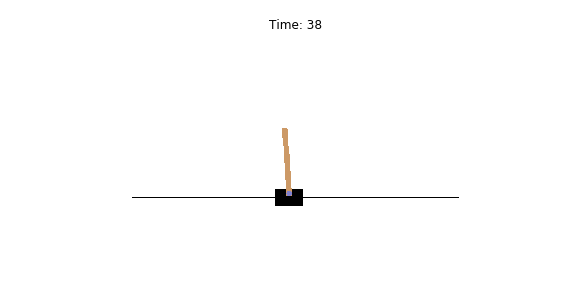
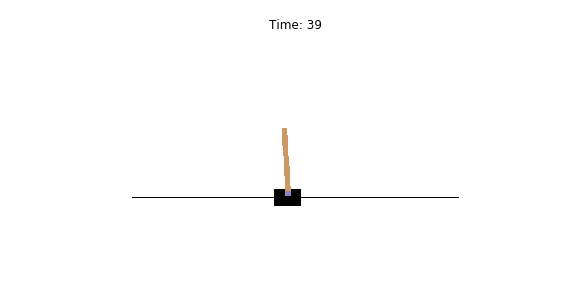
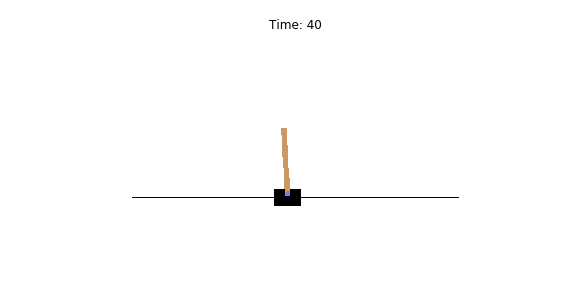
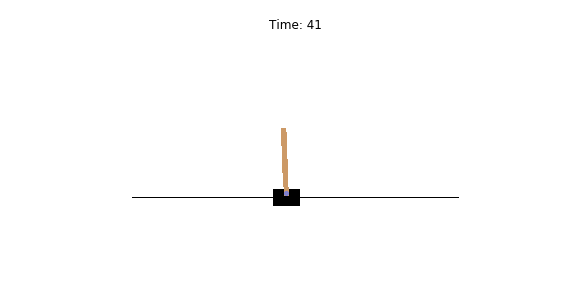
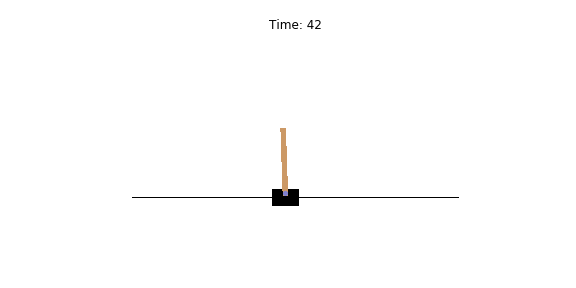
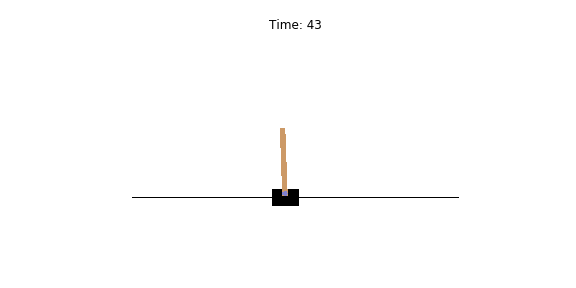
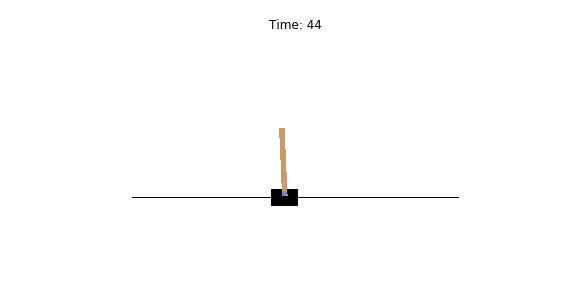
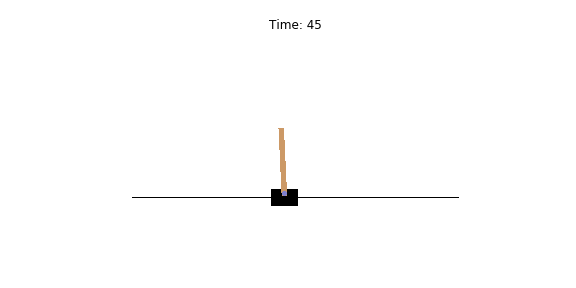
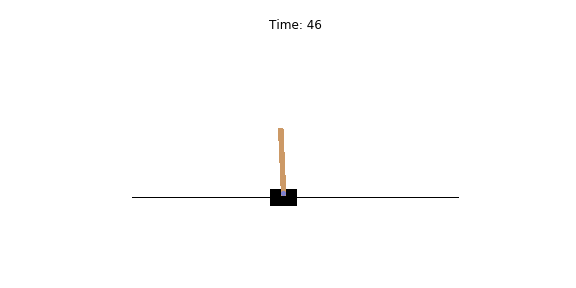
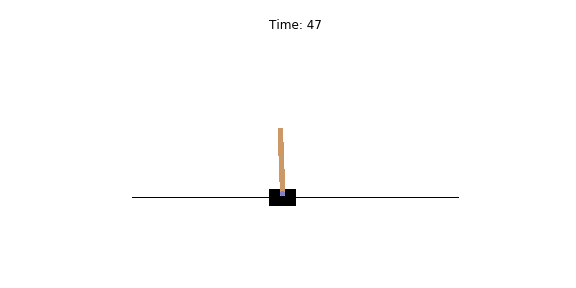
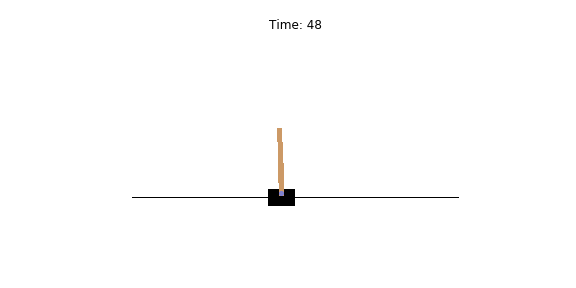
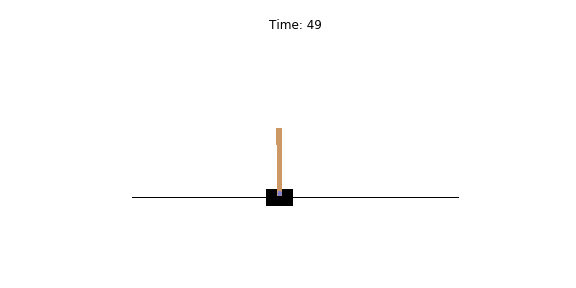
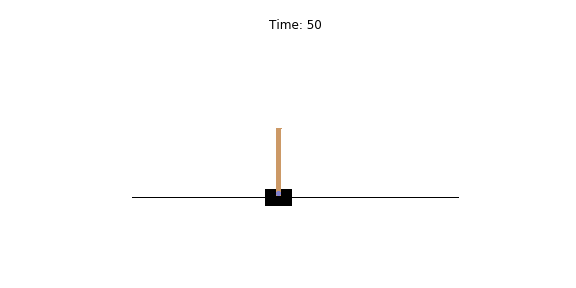
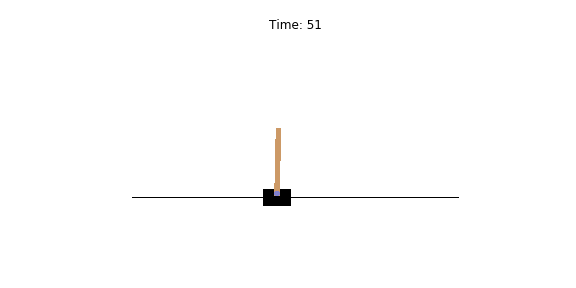
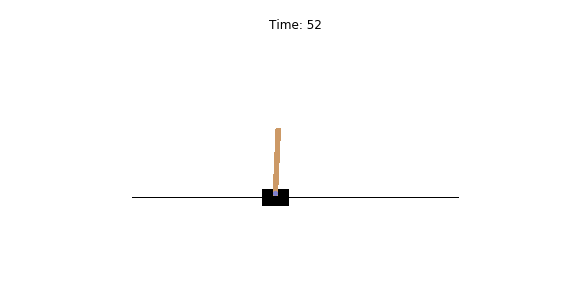
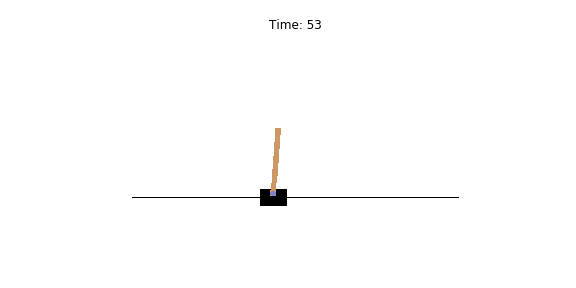
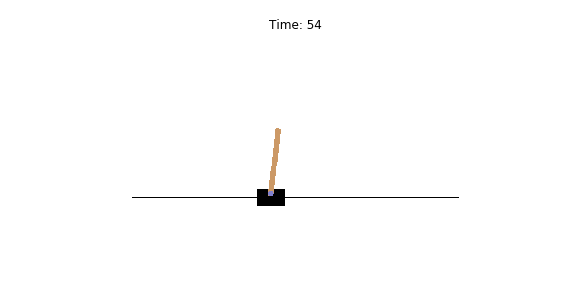
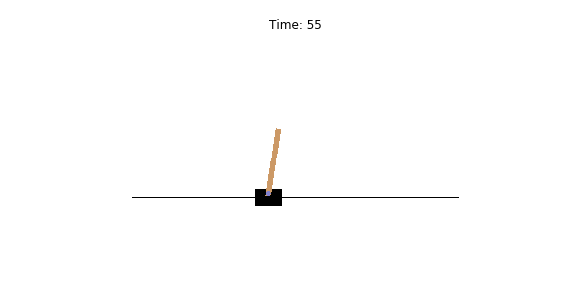

Episode [000] Finished after: [56] steps, Reward: [56.00], Average Reward: [56.00]
Episode [100] Finished after: [10] steps, Reward: [10.00], Average Reward: [15.86]
Episode [200] Finished after: [11] steps, Reward: [11.00], Average Reward: [18.91]
Episode [300] Finished after: [28] steps, Reward: [28.00], Average Reward: [17.21]
Episode [400] Finished after: [30] steps, Reward: [30.00], Average Reward: [24.30]



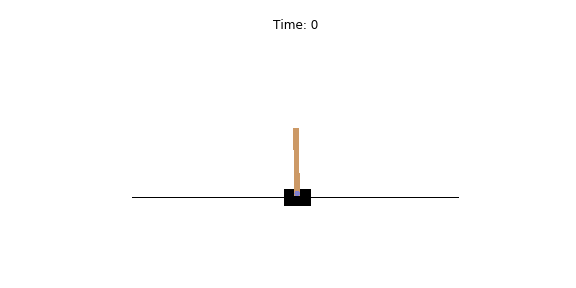
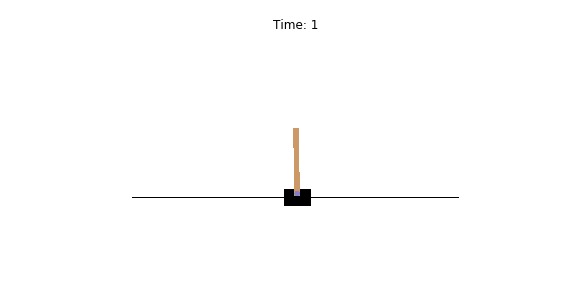
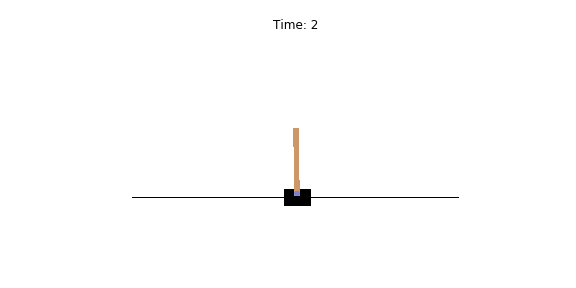
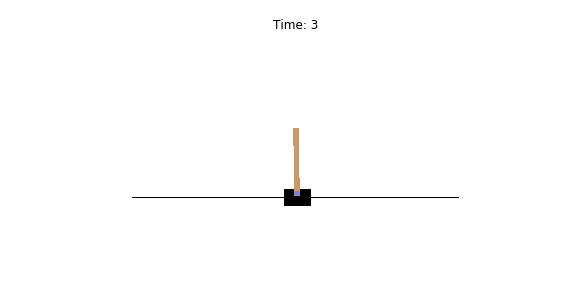
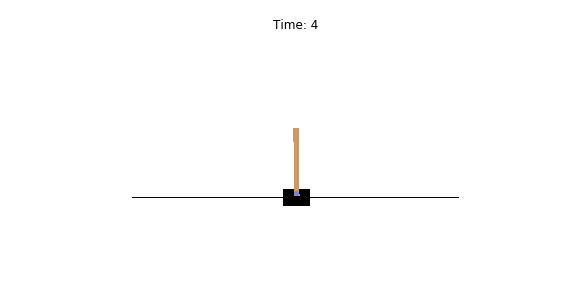
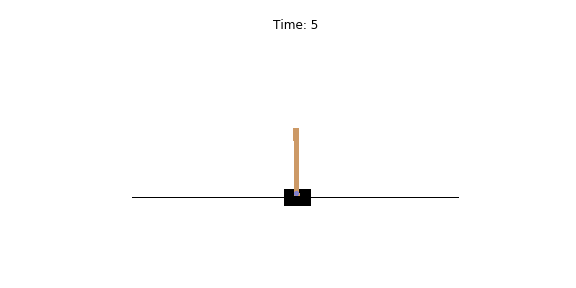
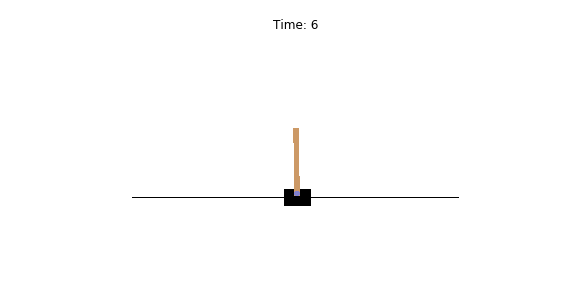
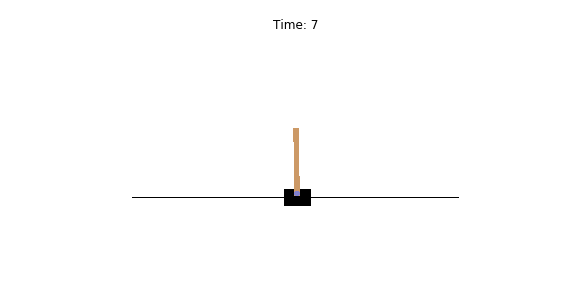
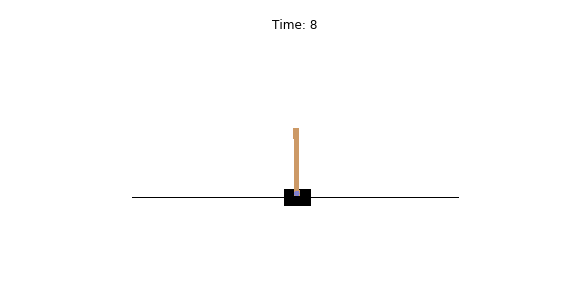
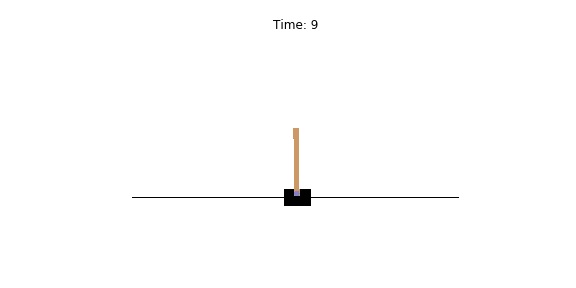
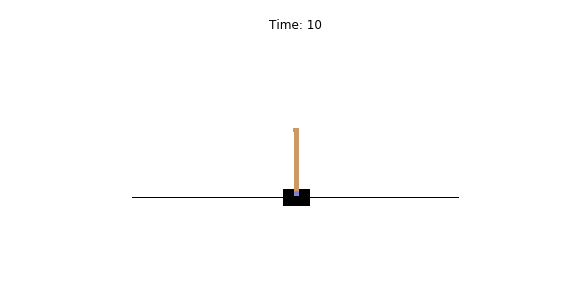
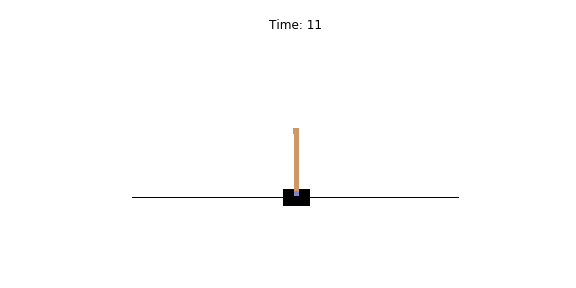
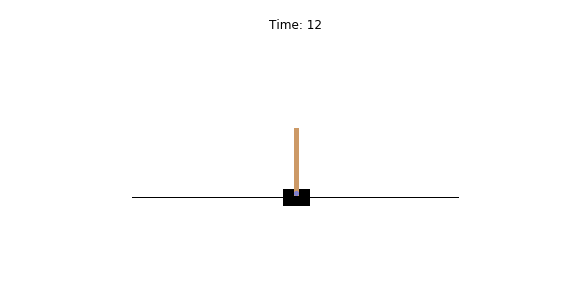
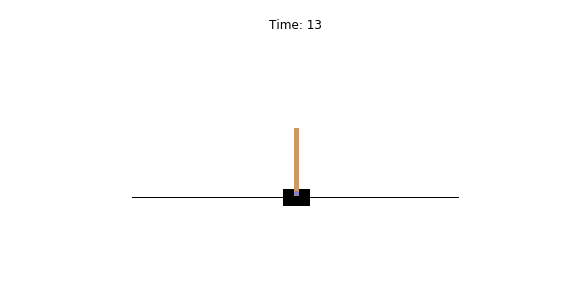
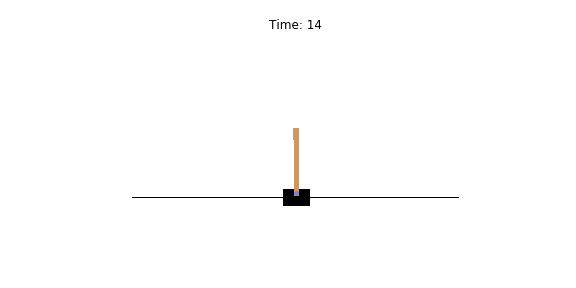
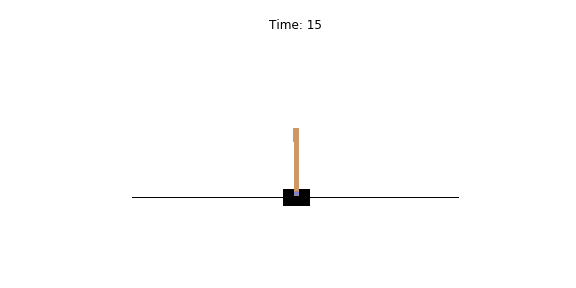
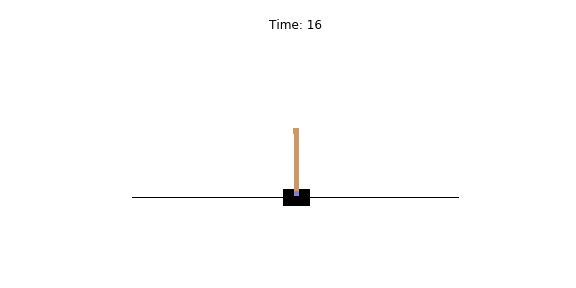
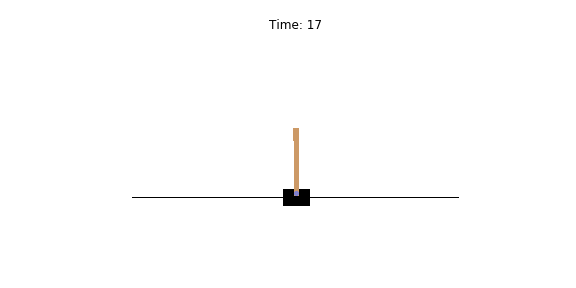
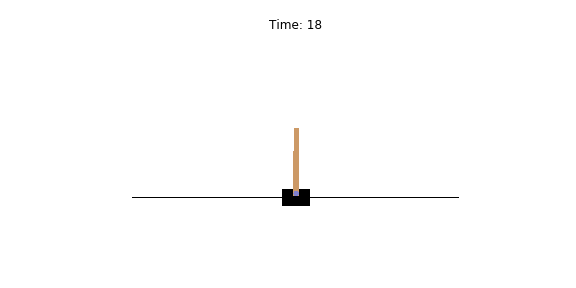
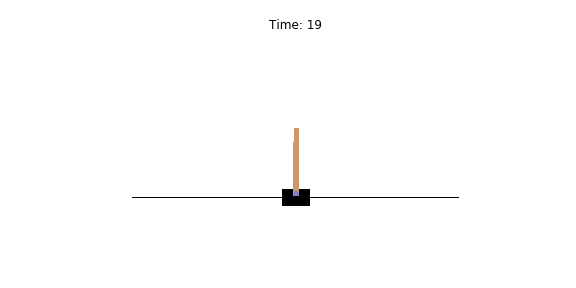
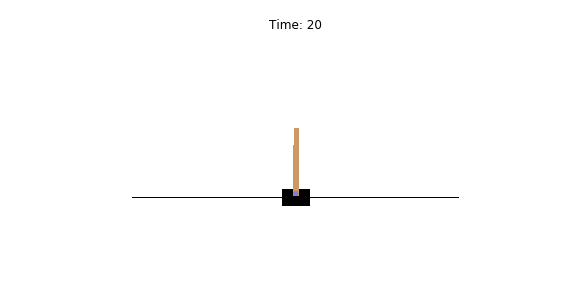
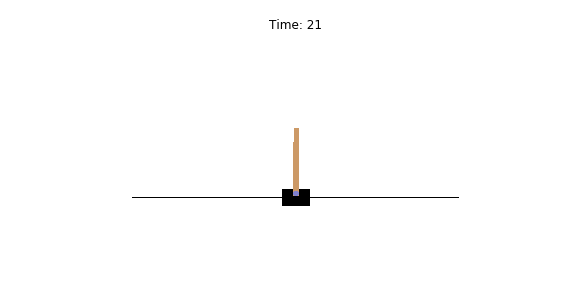
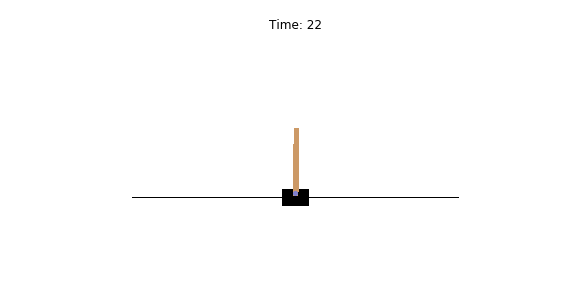
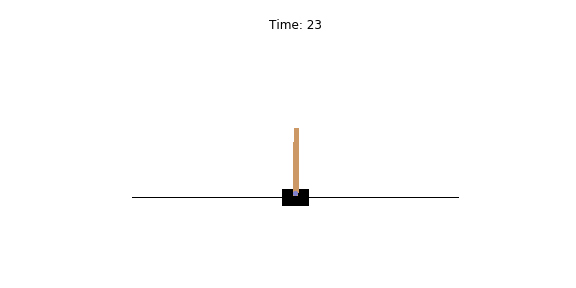
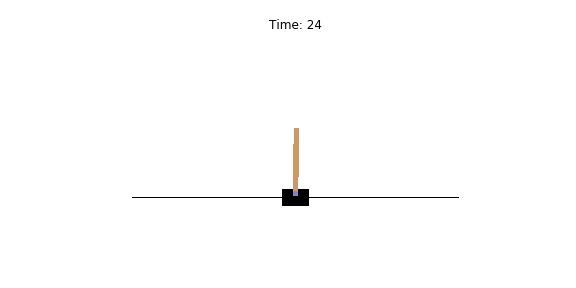
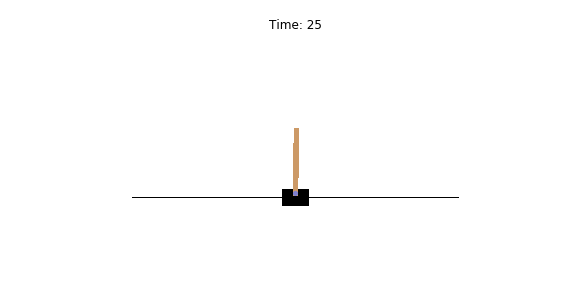
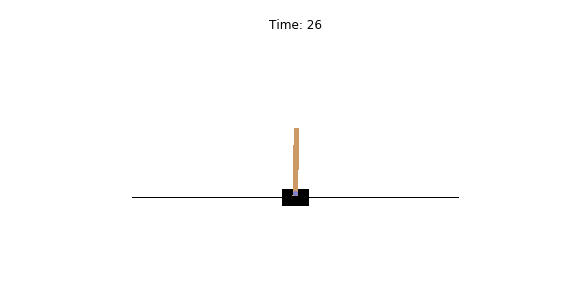
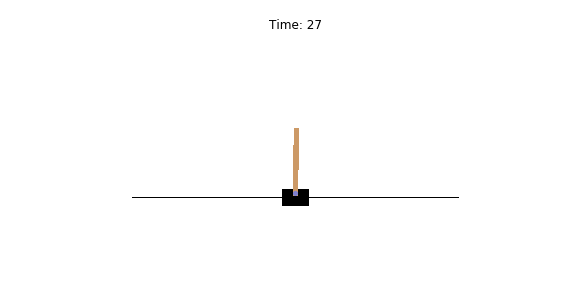
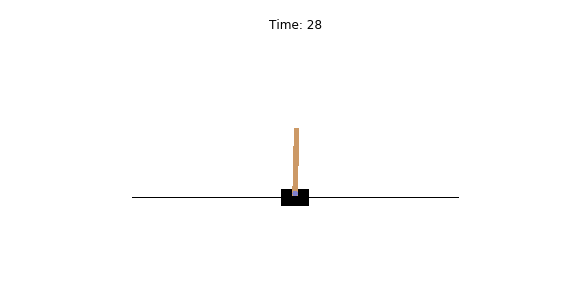
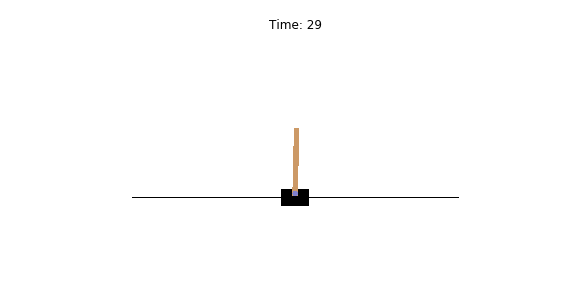
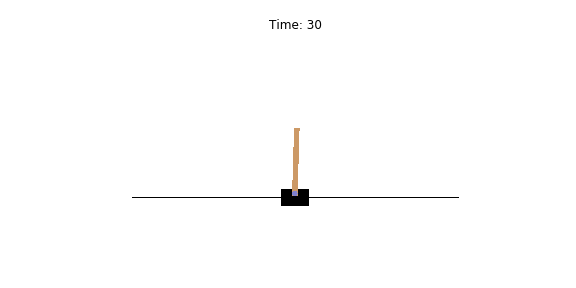
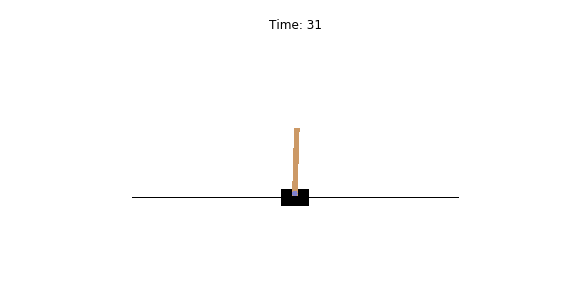
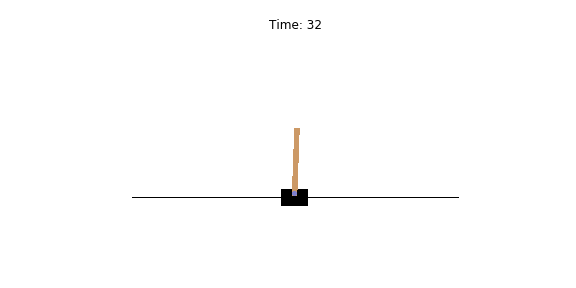
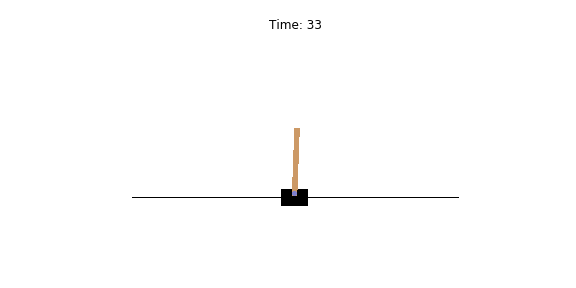
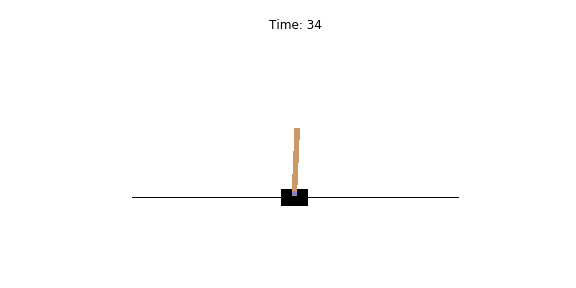
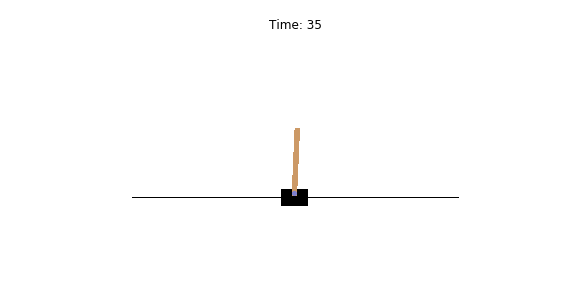
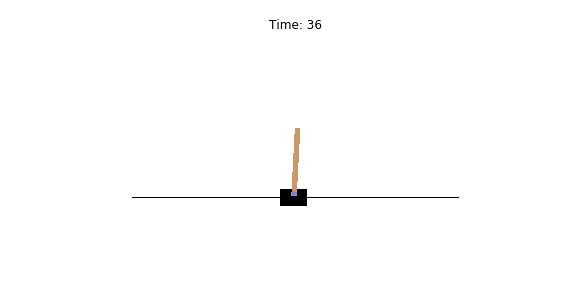
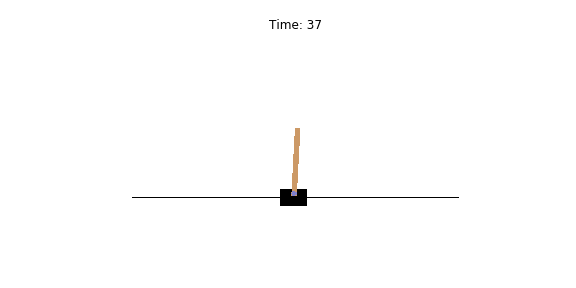
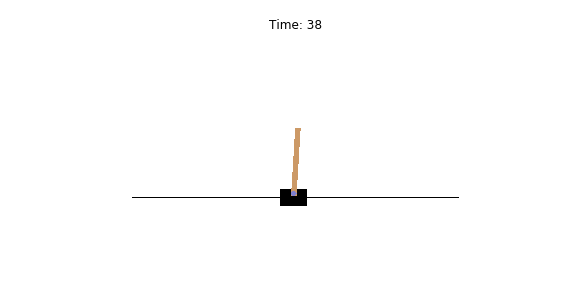
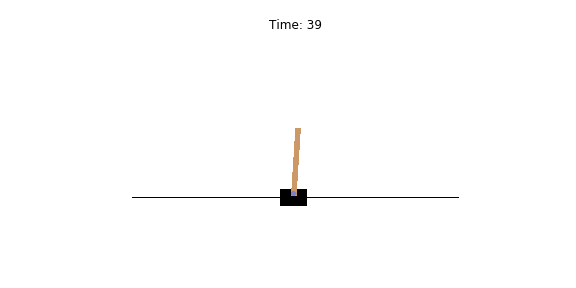
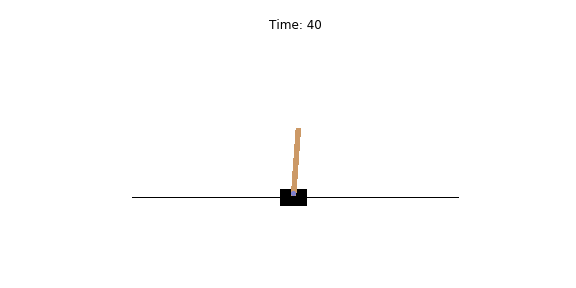
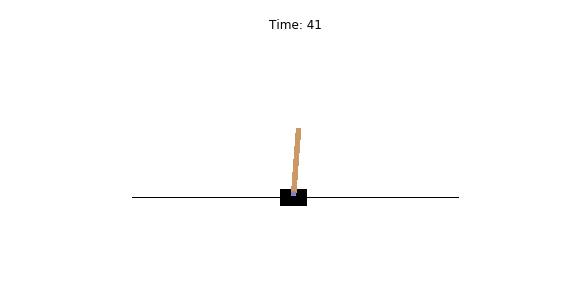
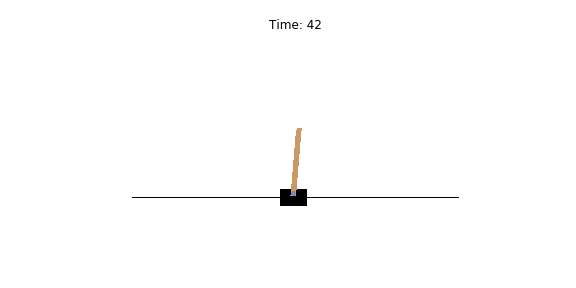
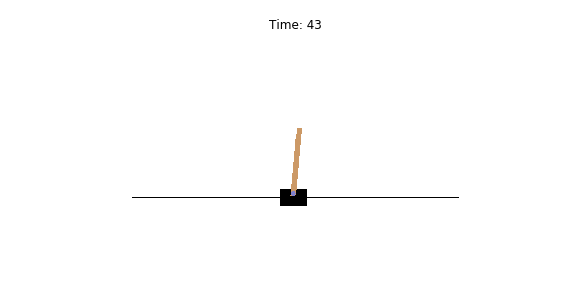
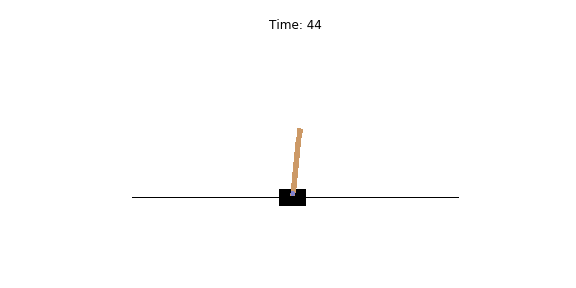
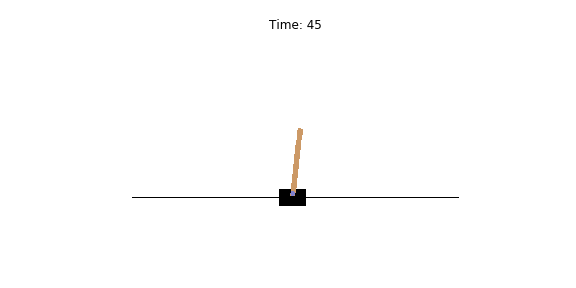
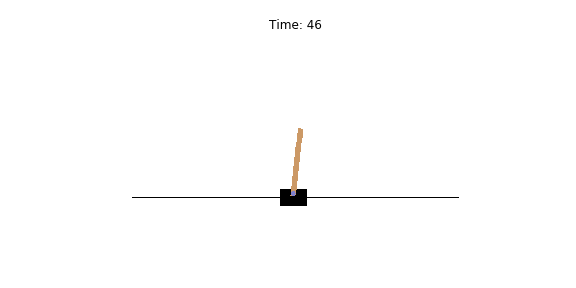
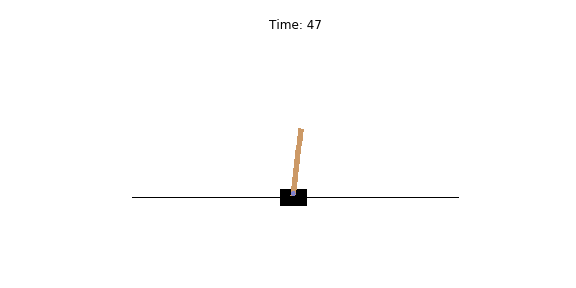
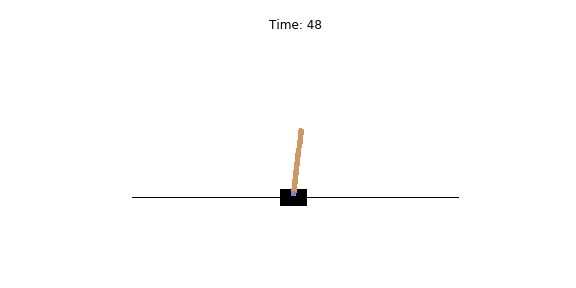
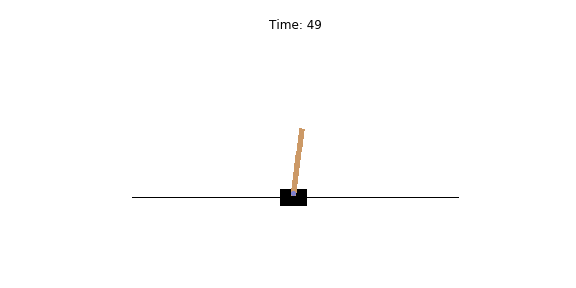
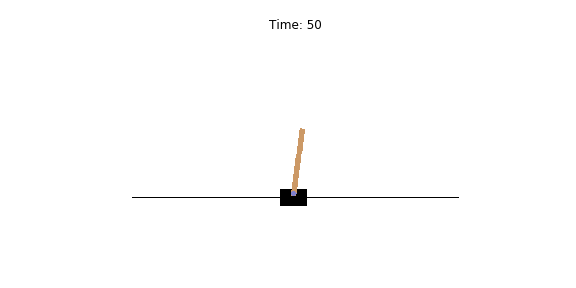
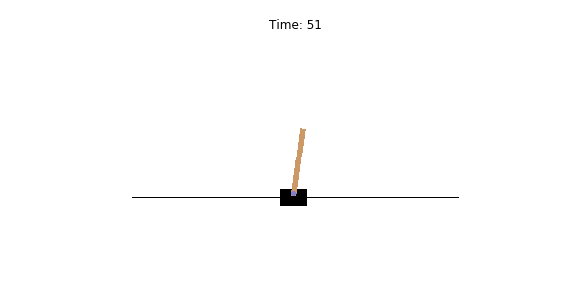
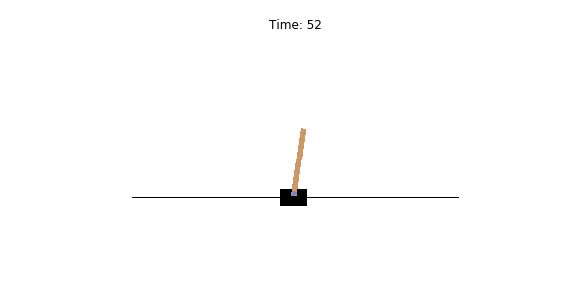
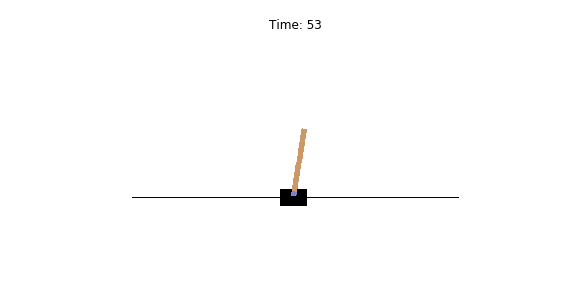
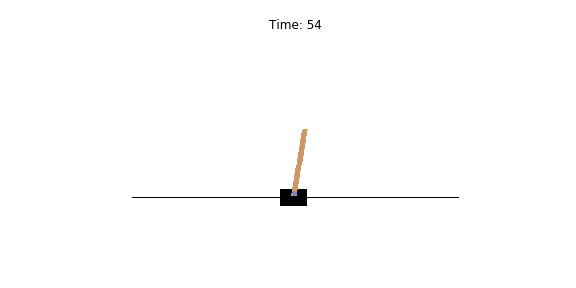
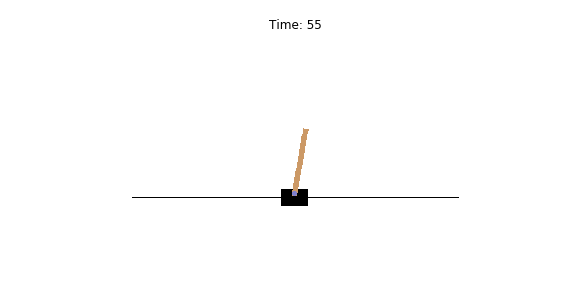
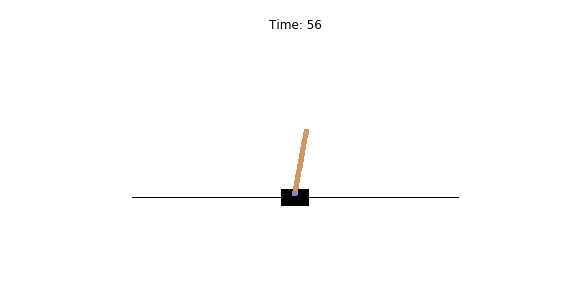
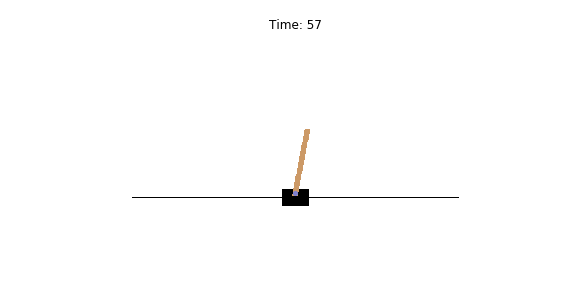
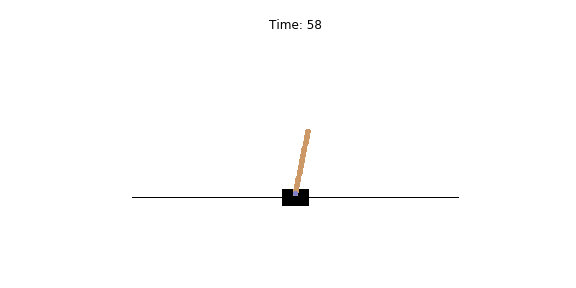
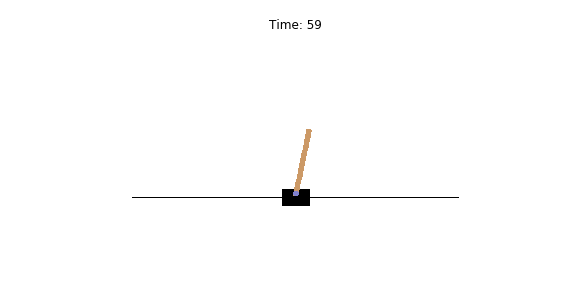

Episode [500] Finished after: [60] steps, Reward: [60.00], Average Reward: [42.03]
Episode [600] Finished after: [56] steps, Reward: [56.00], Average Reward: [48.51]
Episode [700] Finished after: [69] steps, Reward: [69.00], Average Reward: [53.30]
Episode [800] Finished after: [104] steps, Reward: [104.00], Average Reward: [88.42]
Episode [900] Finished after: [195] steps, Reward: [195.00], Average Reward: [160.92]



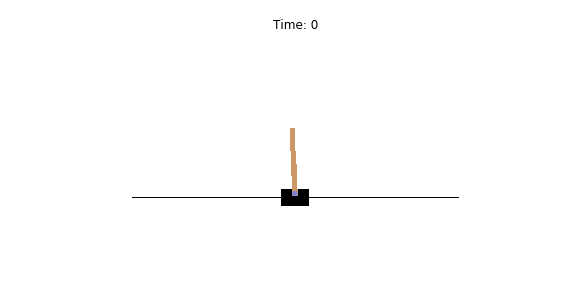
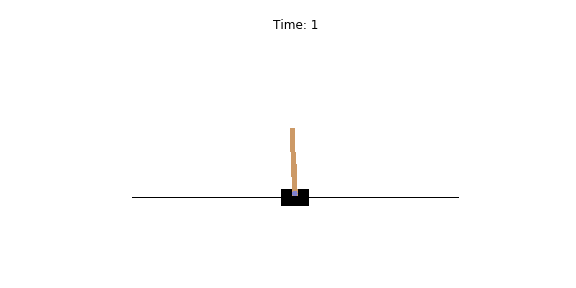
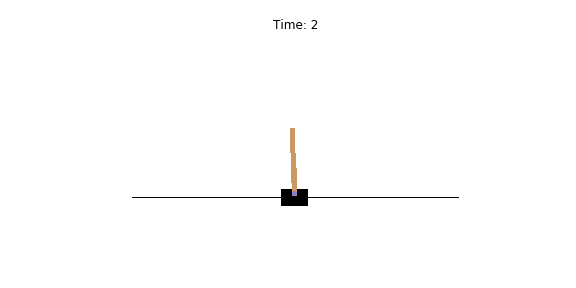
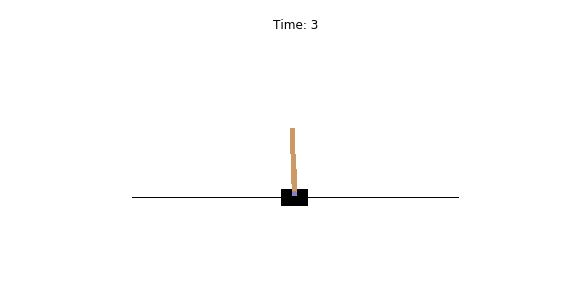
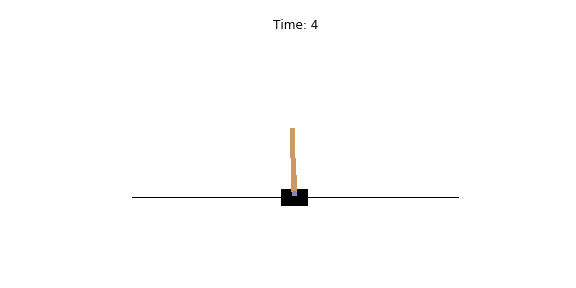
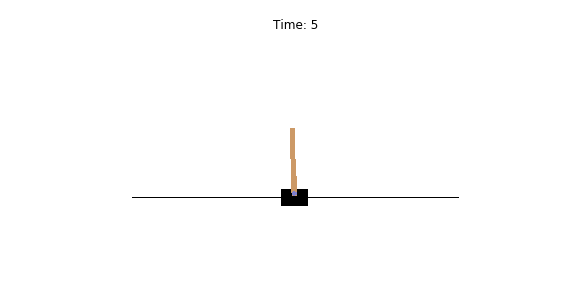
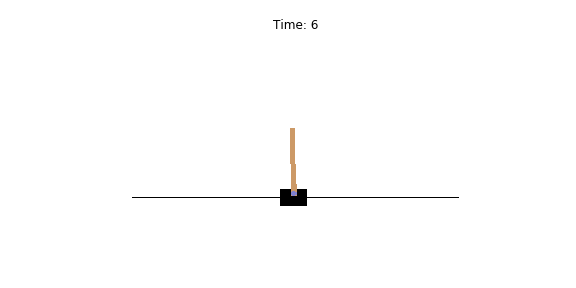
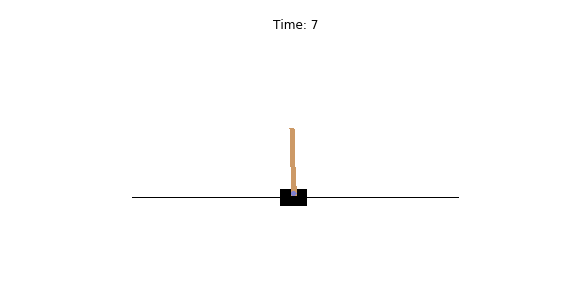
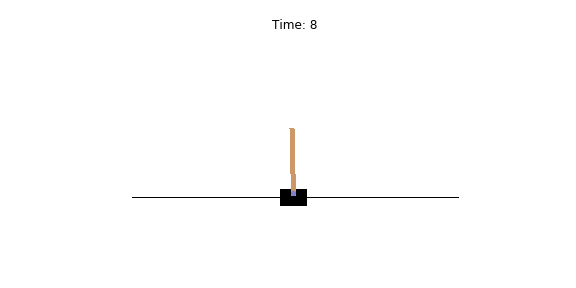
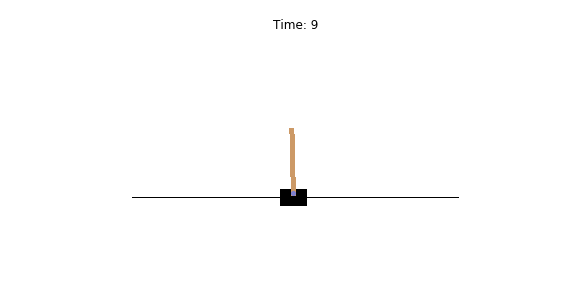
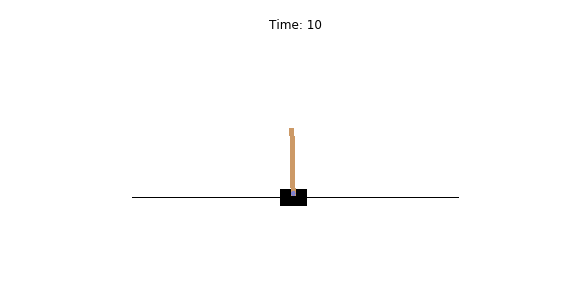
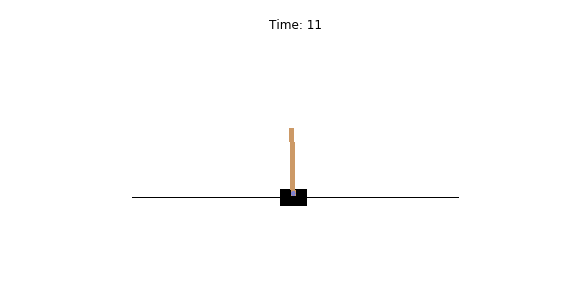
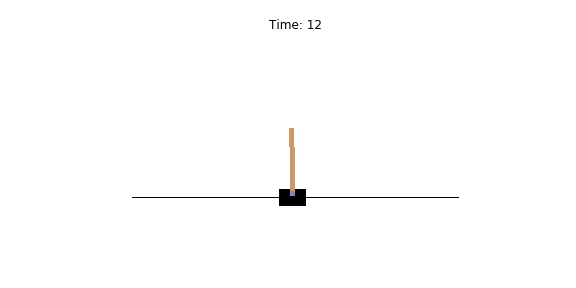
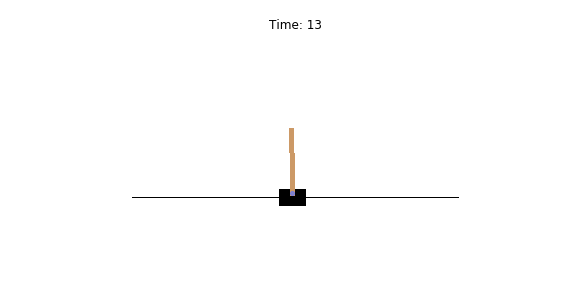
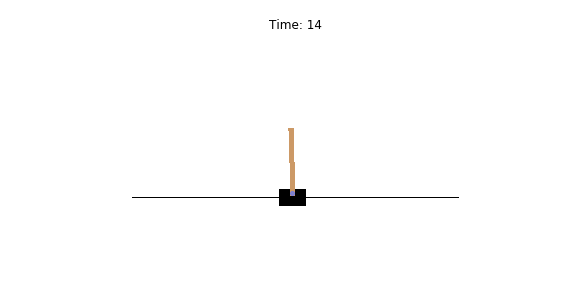
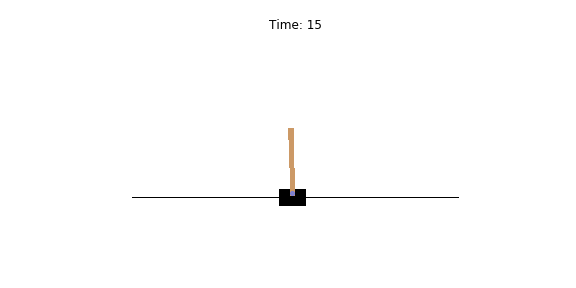
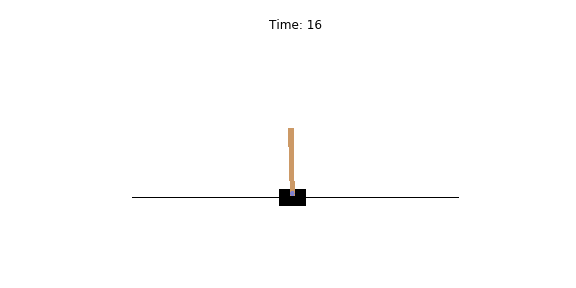
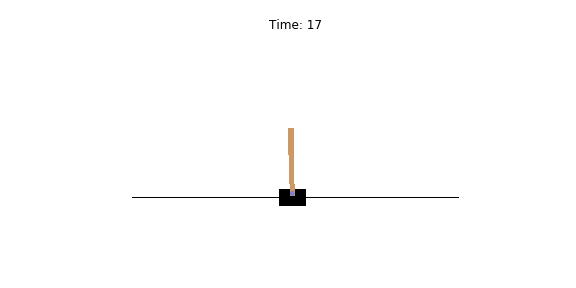
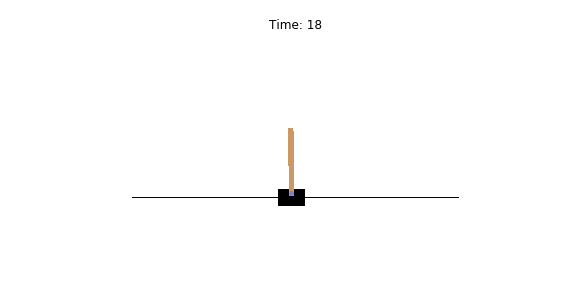
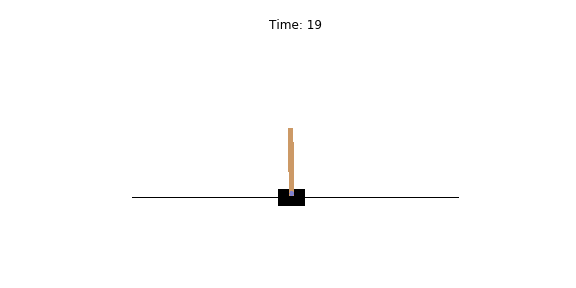
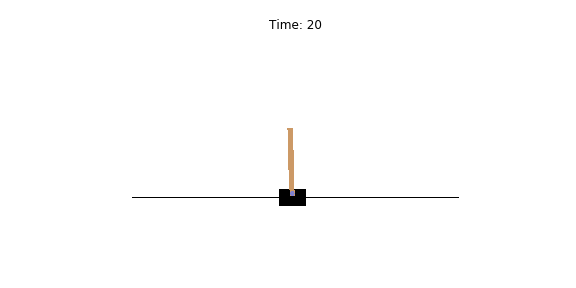
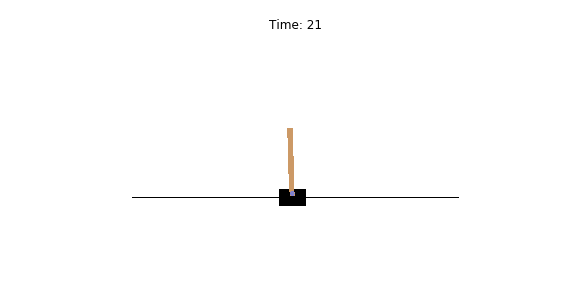
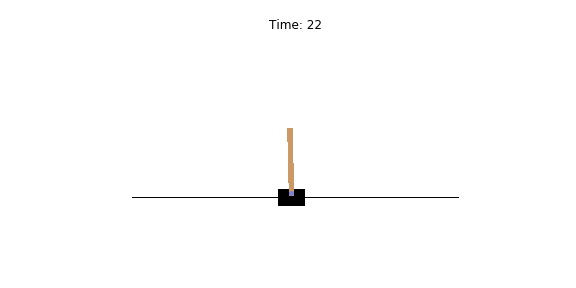
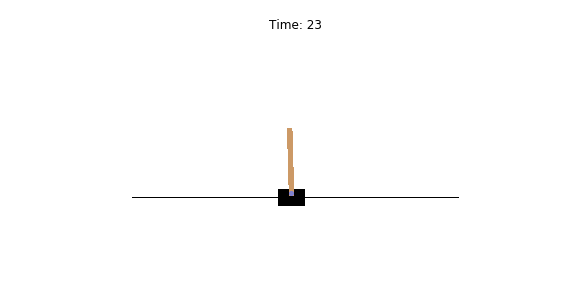
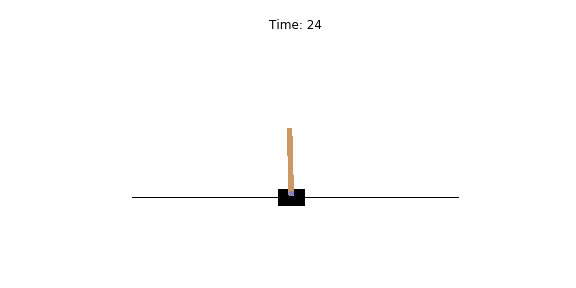
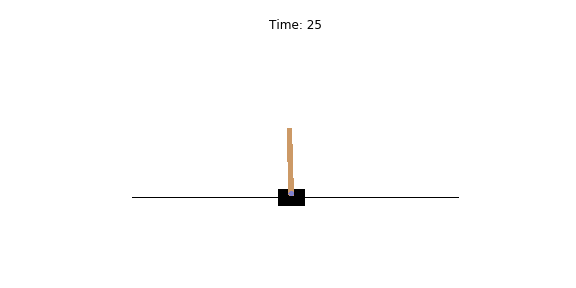
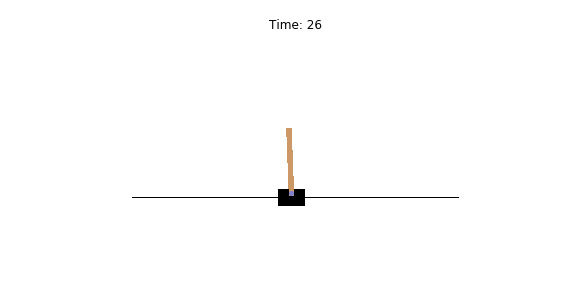
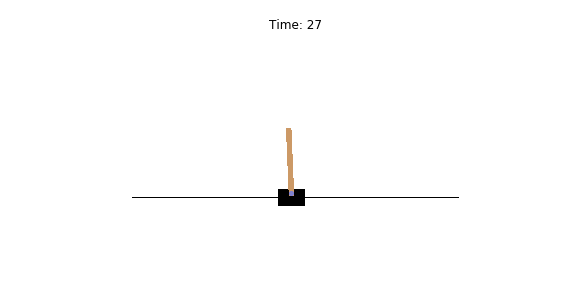
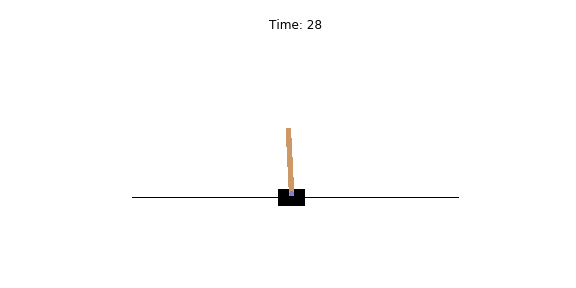
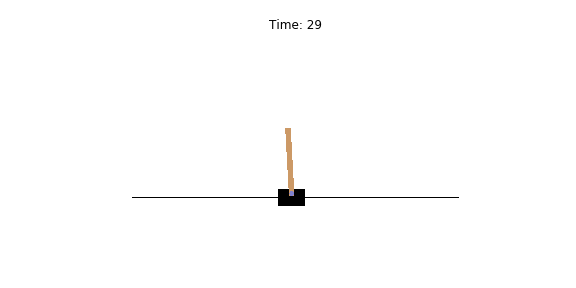
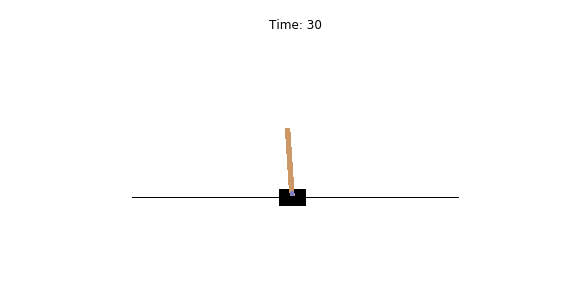
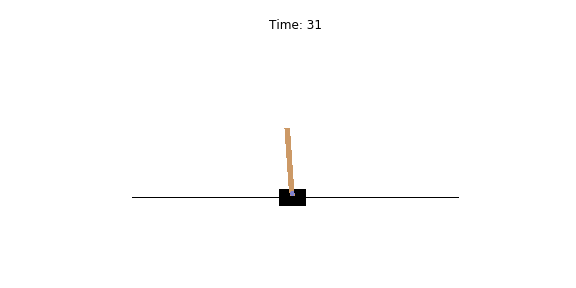
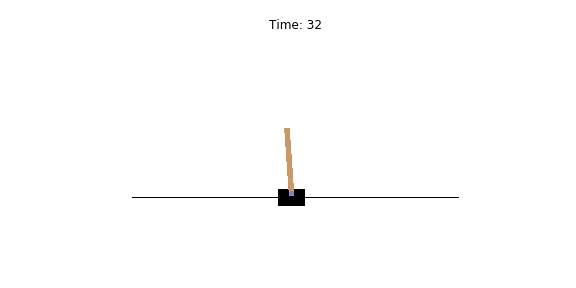
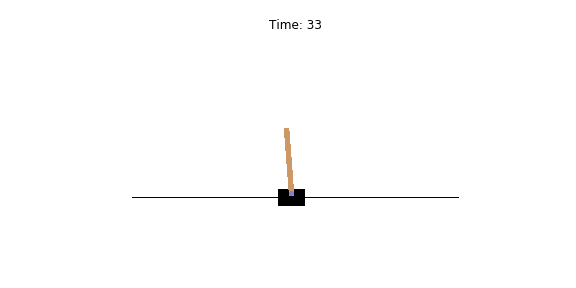
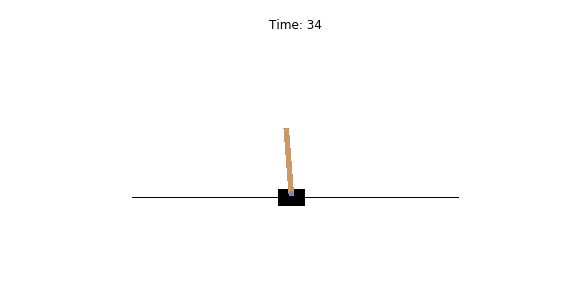
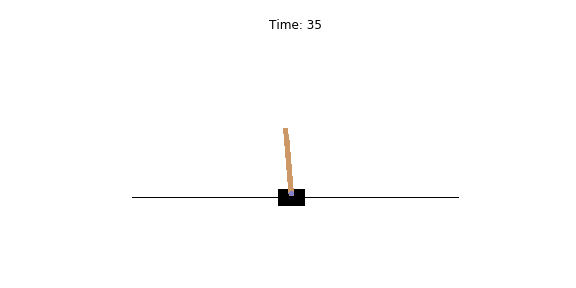
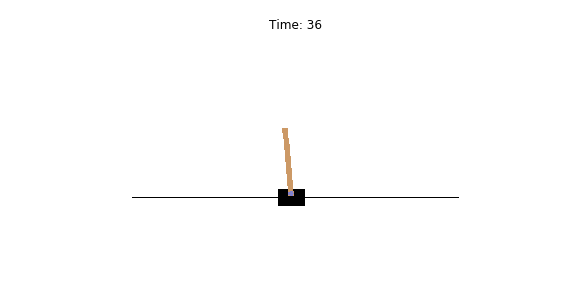
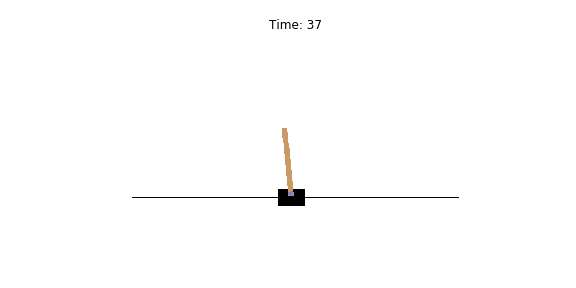
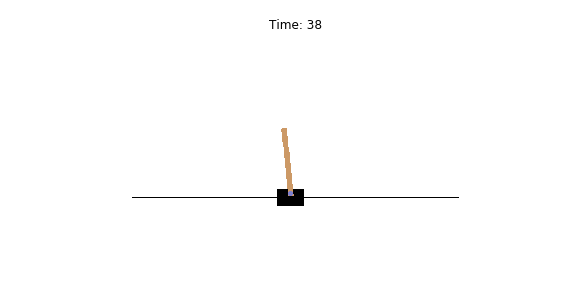
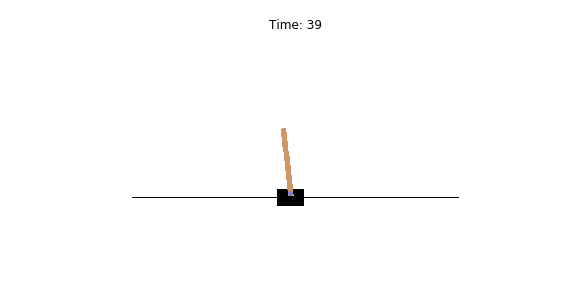
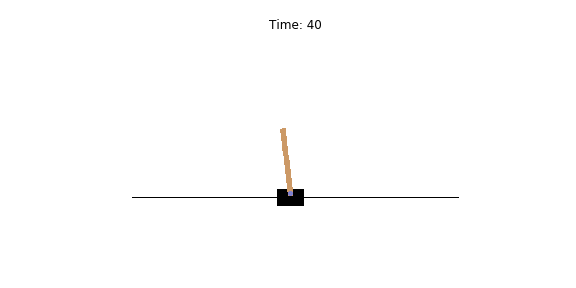
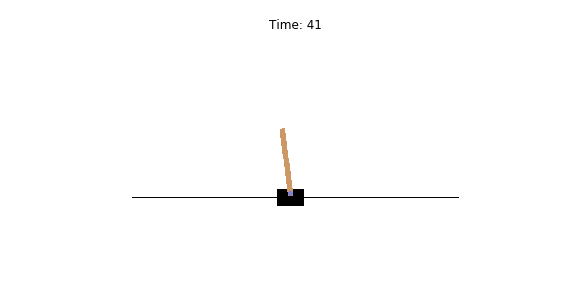
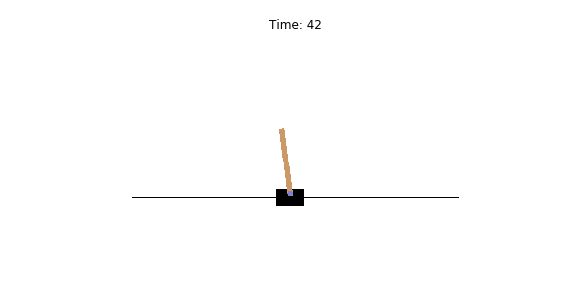
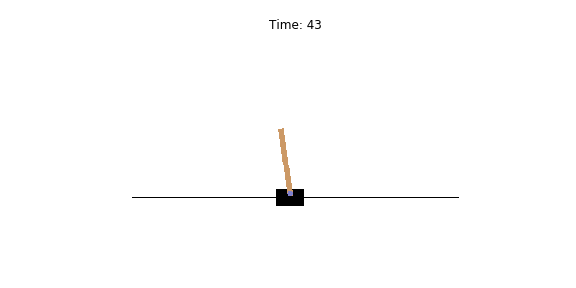
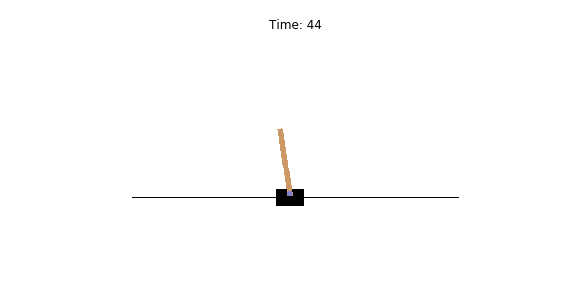
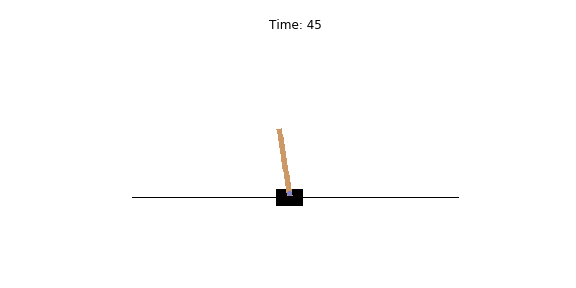
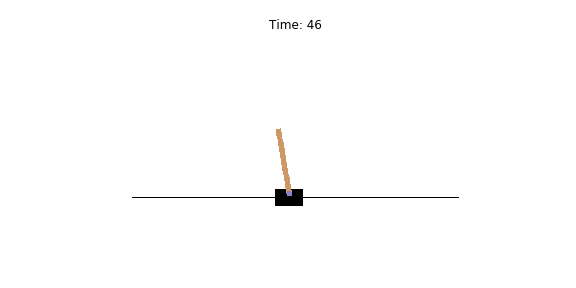
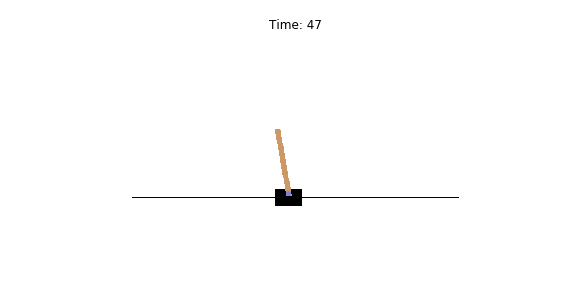
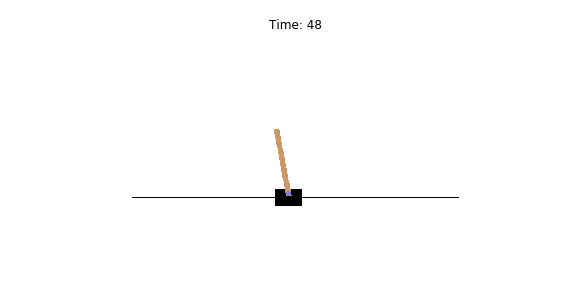
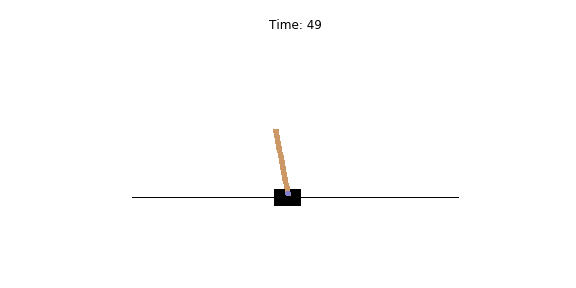
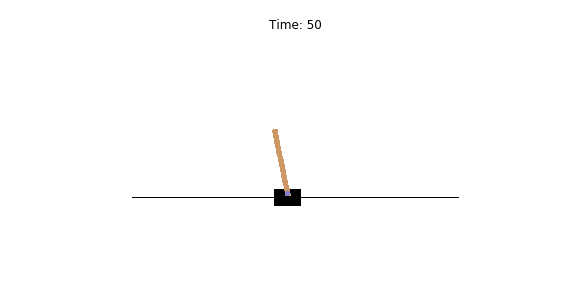

Episode [1000] Finished after: [51] steps, Reward: [51.00], Average Reward: [170.41]
Episode [1100] Finished after: [116] steps, Reward: [116.00], Average Reward: [155.06]
Episode [1200] Finished after: [113] steps, Reward: [113.00], Average Reward: [106.27]
Episode [1300] Finished after: [94] steps, Reward: [94.00], Average Reward: [115.88]
Episode [1400] Finished after: [97] steps, Reward: [97.00], Average Reward: [74.30]


In [ ]:
for i_episode in range(MAX_EPISODES):
    state = env.reset()
    total_rewards = 0
    imgs = []
    for t in range(MAX_STEPS):
        # APPEND CURRENT IMG
        rgbimg = env.render(mode='rgb_array')
        imgs.append(rgbimg)
        # RUN WITH ACTION
        action = q_learner.eGreedyAction(state[np.newaxis,:])
        next_state, reward, done, _ = env.step(action)
        total_rewards += reward
        # reward = -10 if done else 0.1 # normalize reward
        q_learner.storeExperience(state, action, reward, next_state, done)
        # TRAIN MODEL
        q_learner.updateModel()
        state = next_state
        if done: break

    # SAVE HISTORY
    episode_history.append(total_rewards)
    mean_rewards = np.mean(episode_history)

    # PLOT IMAGES
    if (i_episode % 500) is 0:
        display_frames_as_gif(imgs)
        
    # PRINT RESULTS
    if (i_episode % 100) is 0:
        print("Episode [%03d] Finished after: [%d] steps, Reward: [%.2f], Average Reward: [%.2f]" 
              % (i_episode, t+1, total_rewards, mean_rewards))

    # TERMINATE CONDITION
    if mean_rewards >= 195.0:
        print("Environment {} solved after {} episodes".format(env_name, i_episode+1))
        break